# Points of Interest (POI) da Overture Maps

## 0. Configurazione dell'ambiente
Le librerie utilizzate nel seguente progetto, specificate nel file requirements.txt, devono essere installate e importate come segue.

In [ ]:
# Selezione del notebook
platform = 'colab' #@param ['colab', 'jupyter_notebook']

# Selezione del dispositivo di calcolo per l'esecuzione
device = 'cpu' # @param ['cpu', 'cuda']

print(f'Running on "{platform}" using "{device}" device!')

Running on "colab" using "cpu" device!


### 0.1 Installazione delle librerie

#### 0.1.1 Installazione delle librerie tramite Google Colab

In [ ]:
if platform == 'colab':
    !pip install geopandas
    !pip install folium
    !pip install shapely
    !pip install duckdb
    !pip install jupysql --no-warn-script-location
    !pip install duckdb-engine --no-warn-script-location
    !pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00


### 0.1.2 Installazione delle librerie tramite Jupyter Notebook
Per l'utilizzo di Jupyter Notebook è necessario scaricare il file requirements.txt ed eseguirlo tramite il comando riportato di seguito.

In [ ]:
pip install -r ../requirements.txt  --no-warn-script-location

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../requirements.txt'


### 0.2 Import delle librerie

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import shapely
import duckdb
from geopy.geocoders import Nominatim
import time
import json

## 1. Dataset

### 1.1 Configurazione di Google Drive per Google Colab

In [ ]:
# Collegamento a Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### 1.2 Configurazione di DuckDB

Caricamento dell'estensione SQL per il notebook

In [ ]:
%load_ext sql

Creazione della connessione DuckDB in modo esplicito e assegnazione dell'alias per JupySQL

In [ ]:
conn = duckdb.connect('/content/drive/MyDrive/OvertureMaps/overture_maps_data.db')

In [ ]:
%sql conn

Installazione e caricamento delle estensioni

In [ ]:
%%sql
INSTALL spatial;
INSTALL httpfs;
LOAD spatial;
LOAD httpfs;

Running query in 'DuckDBPyConnection'

Success


Configurazione della regione AWS (Amazon Web Services)

In [ ]:
%sql SET s3_region='us-west-2';

Running query in 'DuckDBPyConnection'

Success


Configurazione per la visualizzazione dell'output

In [ ]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Comando da utilizzare per annullare la transazione abortita a causa di un errore a runtime

In [ ]:
%%sql
ROLLBACK;

TransactionException: TransactionContext Error: cannot rollback - no transaction is active

Chiusura della connessione per sincronizzare la sessione

In [ ]:
conn.close()

### 1.3 Caricamento del database

#### 1.3.1 Query di prova

In [ ]:
%%sql
SELECT *
FROM read_parquet('s3://overturemaps-us-west-2/release/2025-02-19.0/theme=places/*/*')
WHERE addresses[1].country = 'IT' AND addresses[1].locality ILIKE 'Milano'
LIMIT 3;

,id,geometry,bbox,version,sources,names,categories,confidence,websites,socials,emails,phones,brand,addresses,theme,type
0,08f8e62c50383b8803fcf09567974e40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'xmin': -76.99663543701172, 'xmax': -76.99662...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'Arteinparete Deco', 'common': Non...","{'primary': 'art_gallery', 'alternate': ['home...",0.794118,[http://www.arteinparete.com/],[https://www.facebook.com/467046626673669],<NA>,[+393884958913],<NA>,"[{'freeform': 'Via dei Transiti, 6', 'locality...",places,place
1,08f98f0b29285aea03652e222d82119b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'xmin': -7.7469072341918945, 'xmax': -7.74690...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'IFDM', 'common': None, 'rules': N...","{'primary': 'print_media', 'alternate': ['medi...",0.784615,[http://www.ifdm.design/],[https://www.facebook.com/48784411852],<NA>,<NA>,<NA>,"[{'freeform': 'Bastioni di Porta Venezia, 9', ...",places,place
2,08f489ac041b5b32030f50bb7abb55ce,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'xmin': -96.86514282226562, 'xmax': -96.86512...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'Spazio Benessere IEO', 'common': ...","{'primary': 'beauty_and_spa', 'alternate': ['c...",0.621434,[https://bit.ly/SpazioBenessereIeo],[https://www.facebook.com/100209162220057],<NA>,[+393519878993],<NA>,"[{'freeform': 'Via Giuseppe Ripamonti, 435', '...",places,place


In [ ]:
%%sql result <<
SELECT *
FROM read_parquet('s3://overturemaps-us-west-2/release/2025-02-19.0/theme=places/*/*')
WHERE array_length(array_filter(addresses, (address) -> address.country = 'IT' AND address.locality ILIKE 'Milano')) > 0
LIMIT 3;

In [ ]:
display(result)

,id,geometry,bbox,version,sources,names,categories,confidence,websites,socials,emails,phones,brand,addresses,theme,type
0,08f8e62c50383b8803fcf09567974e40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'xmin': -76.99663543701172, 'xmax': -76.99662...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'Arteinparete Deco', 'common': Non...","{'primary': 'art_gallery', 'alternate': ['home...",0.794118,[http://www.arteinparete.com/],[https://www.facebook.com/467046626673669],<NA>,[+393884958913],<NA>,"[{'freeform': 'Via dei Transiti, 6', 'locality...",places,place
1,08f98f0b29285aea03652e222d82119b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'xmin': -7.7469072341918945, 'xmax': -7.74690...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'IFDM', 'common': None, 'rules': N...","{'primary': 'print_media', 'alternate': ['medi...",0.784615,[http://www.ifdm.design/],[https://www.facebook.com/48784411852],<NA>,<NA>,<NA>,"[{'freeform': 'Bastioni di Porta Venezia, 9', ...",places,place
2,08f489ac041b5b32030f50bb7abb55ce,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'xmin': -96.86514282226562, 'xmax': -96.86512...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'Spazio Benessere IEO', 'common': ...","{'primary': 'beauty_and_spa', 'alternate': ['c...",0.621434,[https://bit.ly/SpazioBenessereIeo],[https://www.facebook.com/100209162220057],<NA>,[+393519878993],<NA>,"[{'freeform': 'Via Giuseppe Ripamonti, 435', '...",places,place


#### 1.3.2 Ottenimento dei POI da Overture Maps

Categorie del dataset utili per analisi supplementari (prova del download)

In [ ]:
%%sql
COPY (
    SELECT
        id,
        geometry,
        CAST(names AS JSON) AS names,
        CAST(categories AS JSON) AS categories,
        confidence,
        CAST(addresses AS JSON) AS addresses
    FROM read_parquet('s3://overturemaps-us-west-2/release/2025-02-19.0/theme=places/*/*')
    WHERE
        array_length(array_filter(addresses, (address) -> address.country = 'IT' AND address.locality ILIKE 'Milano')) > 0
    LIMIT 3
) TO '/content/drive/MyDrive/OvertureMaps/sample_milano_places.csv'
WITH (HEADER, DELIMITER ',');

,Count
0,3


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/OvertureMaps/sample_milano_places.csv')
display(df)

,id,geometry,names,categories,confidence,addresses
0,08f8e62c50383b8803fcf09567974e40,POINT (-76.9966292 -12.1384177),"{""primary"":""Arteinparete Deco"",""common"":null,""...","{""primary"":""art_gallery"",""alternate"":[""home_im...",0.794118,"[{""freeform"":""Via dei Transiti, 6"",""locality"":..."
1,08f98f0b29285aea03652e222d82119b,POINT (-7.7469063 -19.3050656),"{""primary"":""IFDM"",""common"":null,""rules"":null}","{""primary"":""print_media"",""alternate"":[""media_n...",0.784615,"[{""freeform"":""Bastioni di Porta Venezia, 9"",""l..."
2,08f489ac041b5b32030f50bb7abb55ce,POINT (-96.86513 30.70976),"{""primary"":""Spazio Benessere IEO"",""common"":nul...","{""primary"":""beauty_and_spa"",""alternate"":[""cosm...",0.621434,"[{""freeform"":""Via Giuseppe Ripamonti, 435"",""lo..."


In [ ]:
%%sql
COPY (
    SELECT
        id,
        geometry,
        CAST(names AS JSON) AS names,
        CAST(categories AS JSON) AS categories,
        confidence,
        CAST(addresses AS JSON) AS addresses
    FROM read_parquet('s3://overturemaps-us-west-2/release/2025-02-19.0/theme=places/*/*')
    WHERE
        array_length(array_filter(addresses, (address) -> address.country = 'IT' AND address.locality ILIKE 'Milano')) > 0
    LIMIT 3
) TO '/content/drive/MyDrive/OvertureMaps/sample_milano_places_map.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

,Count
0,3


In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/OvertureMaps/sample_milano_places_map.geojson')
display(gdf)

,id,names,categories,confidence,addresses,geometry
0,08f8e62c50383b8803fcf09567974e40,"{ ""primary"": ""Arteinparete Deco"", ""common"": nu...","{ ""primary"": ""art_gallery"", ""alternate"": [ ""ho...",0.794118,"[ { ""freeform"": ""Via dei Transiti, 6"", ""locali...",POINT (-76.99663 -12.13842)
1,08f98f0b29285aea03652e222d82119b,"{ ""primary"": ""IFDM"", ""common"": null, ""rules"": ...","{ ""primary"": ""print_media"", ""alternate"": [ ""me...",0.784615,"[ { ""freeform"": ""Bastioni di Porta Venezia, 9""...",POINT (-7.74691 -19.30507)
2,08f489ac041b5b32030f50bb7abb55ce,"{ ""primary"": ""Spazio Benessere IEO"", ""common"":...","{ ""primary"": ""beauty_and_spa"", ""alternate"": [ ...",0.621434,"[ { ""freeform"": ""Via Giuseppe Ripamonti, 435"",...",POINT (-96.86513 30.70976)


Analisi delle coordinate

In [ ]:
%%sql
SELECT
    CASE
        WHEN ST_X(geometry) BETWEEN 9.0 AND 9.3 AND ST_Y(geometry) BETWEEN 45.3 AND 45.6
        THEN 'Coordinate corrette'
        ELSE 'Coordinate errate'
    END AS stato_coordinate,
    COUNT(*) AS numero_luoghi
FROM read_parquet('s3://overturemaps-us-west-2/release/2025-02-19.0/theme=places/*/*')
WHERE array_length(array_filter(addresses, (address) -> address.country = 'IT' AND address.locality ILIKE 'Milano')) > 0
GROUP BY stato_coordinate;

,stato_coordinate,numero_luoghi
0,Coordinate errate,216
1,Coordinate corrette,58271


Dataset completo (salvataggio su Drive del database)

In [ ]:
%%sql
CREATE TABLE IF NOT EXISTS places (
    id STRING,
    geometry GEOMETRY,
    version INTEGER,
    sources JSON,
    names JSON,
    categories JSON,
    confidence DOUBLE,
    websites JSON,
    socials JSON,
    emails JSON,
    phones JSON,
    brand JSON,
    addresses JSON
);

,Count


In [ ]:
%%sql
INSERT INTO places
SELECT
    id,
    geometry,
    version,
    CAST(sources AS JSON) AS sources,
    CAST(names AS JSON) AS names,
    CAST(categories AS JSON) AS categories,
    confidence,
    CAST(websites AS JSON) AS websites,
    CAST(socials AS JSON) AS socials,
    CAST(emails AS JSON) AS emails,
    CAST(phones AS JSON) AS phones,
    CAST(brand AS JSON) AS brand,
    CAST(addresses AS JSON) AS addresses
FROM read_parquet('s3://overturemaps-us-west-2/release/2025-02-19.0/theme=places/*/*')
WHERE array_length(array_filter(addresses, (address) -> address.country = 'IT' AND address.locality ILIKE 'Milano')) > 0;

,Count
0,58487


Correzione delle coordinate errate

In [ ]:
%%sql
SELECT COUNT(*) FROM places;

,count_star()
0,350847


In [ ]:
%%sql
SELECT *
FROM places
LIMIT 3;

,id,geometry,version,sources,names,categories,confidence,websites,socials,emails,phones,brand,addresses
0,08f8e62c50383b8803fcf09567974e40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[{""property"":"""",""dataset"":""meta"",""record_id"":""...","{""primary"":""Arteinparete Deco"",""common"":null,""...","{""primary"":""art_gallery"",""alternate"":[""home_im...",0.794118,"[""http://www.arteinparete.com/""]","[""https://www.facebook.com/467046626673669""]",None,"[""+393884958913""]",None,"[{""freeform"":""Via dei Transiti, 6"",""locality"":..."
1,08f98f0b29285aea03652e222d82119b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[{""property"":"""",""dataset"":""meta"",""record_id"":""...","{""primary"":""IFDM"",""common"":null,""rules"":null}","{""primary"":""print_media"",""alternate"":[""media_n...",0.784615,"[""http://www.ifdm.design/""]","[""https://www.facebook.com/48784411852""]",None,None,None,"[{""freeform"":""Bastioni di Porta Venezia, 9"",""l..."
2,08f489ac041b5b32030f50bb7abb55ce,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[{""property"":"""",""dataset"":""meta"",""record_id"":""...","{""primary"":""Spazio Benessere IEO"",""common"":nul...","{""primary"":""beauty_and_spa"",""alternate"":[""cosm...",0.621434,"[""https://bit.ly/SpazioBenessereIeo""]","[""https://www.facebook.com/100209162220057""]",None,"[""+393519878993""]",None,"[{""freeform"":""Via Giuseppe Ripamonti, 435"",""lo..."


In [ ]:
%%sql wrong_addresses <<
SELECT id, addresses, geometry
FROM places
WHERE
    CAST(addresses[0]->>'country' AS STRING) = 'IT'
    AND CAST(addresses[0]->>'locality' AS STRING) ILIKE 'Milano'
    AND (ST_X(geometry) NOT BETWEEN 9.0 AND 9.3 OR ST_Y(geometry) NOT BETWEEN 45.3 AND 45.6);

In [ ]:
print(wrong_addresses.shape)

(216, 3)


Utilizzo di Nominatim per ottenere in automatico le coordinate a partire dagli indirizzi

In [ ]:
geolocator = Nominatim(user_agent="Geocoding s.carbone17@campus.unimib.it)", timeout=10)
updated_data = []
new_addresses_count = 0
wrong_addresses_count = 0

for row in wrong_addresses.iterrows():
    id_value = row[1]['id']
    address = json.loads(row[1]['addresses'])
    address_str = address[0]['freeform'] + ", " + address[0]['locality'] + ", " + address[0]['postcode'] + ", " + address[0]['country']

    location = geolocator.geocode(address_str)
    if location:
        new_addresses_count += 1
        updated_data.append((id_value, location.latitude, location.longitude))
    else:
        wrong_addresses_count += 1

    time.sleep(1.5)

print(f"Numero di coordinate ottenute: {new_addresses_count}.")
print(f"Numero di coordinate ancora errate: {wrong_addresses_count}.")

Numero di coordinate ottenute: 194.
Numero di coordinate ancora errate: 22.


Aggiornamento delle coordinate ottenute

In [ ]:
df_updates = pd.DataFrame(updated_data, columns=["id", "longitude", "latitude"])

In [ ]:
conn.sql("CREATE TABLE temp_updates AS SELECT * FROM df_updates")

In [ ]:
%%sql
UPDATE places
SET geometry = ST_Point(temp_updates.latitude, temp_updates.longitude)
FROM temp_updates
WHERE places.id = temp_updates.id;

,Count
0,1144


In [ ]:
%%sql
SELECT
    CASE
        WHEN ST_X(geometry) BETWEEN 9.0 AND 9.3 AND ST_Y(geometry) BETWEEN 45.3 AND 45.6
        THEN 'Coordinate corrette'
        ELSE 'Coordinate errate'
    END AS stato_coordinate,
    COUNT(*) AS numero_luoghi
FROM places
GROUP BY stato_coordinate;

,stato_coordinate,numero_luoghi
0,Coordinate corrette,350792
1,Coordinate errate,55


In [ ]:
%%sql
DROP TABLE IF EXISTS temp_updates;

,Success


Gestione manuale dei dati con coordinate ancora errate

In [ ]:
%%sql
SELECT id, names, addresses, ST_X(geometry), ST_Y(geometry)
FROM places
WHERE NOT (ST_X(geometry) BETWEEN 9.0 AND 9.3 AND ST_Y(geometry) BETWEEN 45.3 AND 45.6);

,id,names,addresses,st_x(geometry),st_y(geometry)
0,08f1e8321b28143303449410223d9261,"{""primary"":""Angels & Demons"",""common"":null,""ru...","[{""freeform"":""Corso Italia, 15"",""locality"":""Mi...",8.916926,45.596460
1,08f1f9817401bd1e03e04e4651aad519,"{""primary"":""HADO"",""common"":null,""rules"":null}","[{""freeform"":""Viale Abruzzi, 13"",""locality"":""M...",9.316580,45.455656
2,08f1f99c8ea06c88037e9a3cd8e9df6c,"{""primary"":""Studio Baccani E Associati"",""commo...","[{""freeform"":""Piazza Camillo Benso di Cavour, ...",9.373221,45.538461
3,08f1f99c51b1340e03767799cad1a79a,"{""primary"":""WWG Software Company"",""common"":nul...","[{""freeform"":""Corso Europa, 15"",""locality"":""Mi...",9.384619,45.547842
4,08f1f9993221ab5b032b795d558a9c78,"{""primary"":""Azienda Agricola San Martino"",""com...","[{""freeform"":""Via San Martino, 7"",""locality"":""...",9.310525,45.421381
5,08f1e8321b28143303449410223d9261,"{""primary"":""Angels & Demons"",""common"":null,""ru...","[{""freeform"":""Corso Italia, 15"",""locality"":""Mi...",8.916926,45.596460
6,08f1f9817401bd1e03e04e4651aad519,"{""primary"":""HADO"",""common"":null,""rules"":null}","[{""freeform"":""Viale Abruzzi, 13"",""locality"":""M...",9.316580,45.455656
7,08f1f99c8ea06c88037e9a3cd8e9df6c,"{""primary"":""Studio Baccani E Associati"",""commo...","[{""freeform"":""Piazza Camillo Benso di Cavour, ...",9.373221,45.538461
8,08f1f99c51b1340e03767799cad1a79a,"{""primary"":""WWG Software Company"",""common"":nul...","[{""freeform"":""Corso Europa, 15"",""locality"":""Mi...",9.384619,45.547842
9,08f1f9993221ab5b032b795d558a9c78,"{""primary"":""Azienda Agricola San Martino"",""com...","[{""freeform"":""Via San Martino, 7"",""locality"":""...",9.310525,45.421381


In [ ]:
new_data = []
data_to_eliminate = []

new_data.append(('08f6d693050420a903d8dc9a14652b7d', 45.489444, 9.167222))
new_data.append(('08f7b48d16c70b7203d9e47e8434e3d8', 45.4725, 9.153333))
new_data.append(('08f1f986f614b8c003e6cec49f5e0030', 45.4575, 9.187222))
new_data.append(('08f1ea2d937248d503c0edc1cb1cc696', 45.482222, 9.1975))
new_data.append(('08f3f26190bb471903ba34413997d0ea', 45.467778, 9.195556))

new_data.append(('08f1e8624963171203cad59f37e01220', 45.455556, 9.147222))
new_data.append(('08f1e8321b28143303449410223d9261', 45.458056, 9.188611))
new_data.append(('08f1ea201230642e03f59c8f6ee4f00e', 45.468333, 9.195833))
new_data.append(('08f1ea32b00a8add03363d222d0bc1bb', 45.467778, 9.195556))
new_data.append(('08f1f9817401bd1e03e04e4651aad519', 45.475556, 9.216667))

data_to_eliminate.append('08f1f9836526339e03275f45ebbb673e') #Turbigo
data_to_eliminate.append('08f1f99db454830803df2c15a2d08843') #Ferno (Varese)
data_to_eliminate.append('08f1f982682a356a034203cd227acb52') #Abbiategrasso
new_data.append(('08f1f99c8ea06c88037e9a3cd8e9df6c', 45.472778, 9.194722))
data_to_eliminate.append('08f1f995695568e003c937af4fcb04f9') #Buccinasco

data_to_eliminate.append('08f1f9956952c284031bace16697bd70') #Buccinasco
data_to_eliminate.append('08f1f9956952c28403a7adf2b4c1ea4b') #Buccinasco
new_data.append(('08f1f99c51b1340e03767799cad1a79a', 45.465, 9.196667))
new_data.append(('08f1f99c5d4c4c54034ac53d8c9e61bb', 45.496944, 9.197778))
data_to_eliminate.append('08f1f991b181a682037dcb2ba0cd8e1a') #Carugate

data_to_eliminate.append('08f1f991b18c298c030cfd3726bde0e8') #Carugate
data_to_eliminate.append('08f1f991b1125312037dae1ed25a507f') #Buccinasco
data_to_eliminate.append('08f1f991b181d6a003a2c77feac136c3') #Carugate
data_to_eliminate.append('08f1f99185030aa403ba7a030dee4e91') #Gessate
new_data.append(('08f1f9972512160603ae06bdf6f912b0', 45.465833, 9.198889))

data_to_eliminate.append('08f1f99d663a8ce00377eb727e90bfee') #Baggio
new_data.append(('08f1f99d6621b41a03c01a716c59cf8c', 45.467778, 9.195556))
new_data.append(('08f1f9993221ab5b032b795d558a9c78', 45.453056, 9.188333))
new_data.append(('08f1f8eaf24e924803f8eecc82c76b08', 45.478333, 9.194722))
new_data.append(('08f1ea422910512d034db04844fa6a18', 45.462778, 9.192778))

df_correct = pd.DataFrame(new_data, columns=["id", "longitude", "latitude"])
df_eliminate = pd.DataFrame(data_to_eliminate, columns=["id"])

In [ ]:
display(df_correct.shape)
display(df_eliminate.shape)

(18, 3)

(12, 1)

Aggiornamento delle nuove coordinate dei POI di Milano

In [ ]:
conn.sql("CREATE TABLE temp_correct AS SELECT * FROM df_correct")

In [ ]:
%%sql
UPDATE places
SET geometry = ST_Point(temp_correct.latitude, temp_correct.longitude)
FROM temp_correct
WHERE places.id = temp_correct.id;

,Count
0,108


In [ ]:
%%sql
SELECT
    CASE
        WHEN ST_X(geometry) BETWEEN 9.0 AND 9.3 AND ST_Y(geometry) BETWEEN 45.3 AND 45.6
        THEN 'Coordinate corrette'
        ELSE 'Coordinate errate'
    END AS stato_coordinate,
    COUNT(*) AS numero_luoghi
FROM places
GROUP BY stato_coordinate;

,stato_coordinate,numero_luoghi
0,Coordinate corrette,350835
1,Coordinate errate,12


Eliminazione dei POI esterni a Milano

In [ ]:
conn.sql("CREATE TABLE temp_eliminate AS SELECT * FROM df_eliminate")

In [ ]:
%%sql
DELETE FROM places
WHERE id IN (SELECT id FROM temp_eliminate);

,Count
0,12


In [ ]:
%%sql
SELECT
    CASE
        WHEN ST_X(geometry) BETWEEN 9.0 AND 9.3 AND ST_Y(geometry) BETWEEN 45.3 AND 45.6
        THEN 'Coordinate corrette'
        ELSE 'Coordinate errate'
    END AS stato_coordinate,
    COUNT(*) AS numero_luoghi
FROM places
GROUP BY stato_coordinate;

,stato_coordinate,numero_luoghi
0,Coordinate corrette,350835


In [ ]:
%%sql
DROP TABLE IF EXISTS temp_correct;
DROP TABLE IF EXISTS temp_eliminate;

,Success


Ulteriore analisi della qualità dei dati

In [ ]:
%%sql
SELECT addresses[0]->>'region' AS region, COUNT(*)
FROM places
GROUP BY region;

,region,count_star()
0,MI,298198
1,None,3
2,25,52631
3,MB,3


In [ ]:
%%sql
SELECT id, names, addresses
FROM places
WHERE (addresses[0]->>'region' = 'MB') OR (addresses[0]->>'region' IS NULL);

,id,names,addresses
0,08f1f9950e370b52030914dbc9ac05d8,"{""primary"":""Hertz Autonoleggio - Milan Nova Mi...","[{""freeform"":""S.S. 35 dei Giovi km 135"",""local..."
1,08f1f9950e370b52031fa957bd0cfd7e,"{""primary"":""Hertz Milano Nova Milanese Leroy M...","[{""freeform"":""S.S. 35 dei Giovi km 135"",""local..."
2,08f1f99cf40563ae033144f676924875,"{""primary"":""Endless Pools Italia"",""common"":nul...","[{""freeform"":""Via Vincenzo Monti 8"",""locality""..."
3,08f1f99c0dc552b003ad1408a2d83486,"{""primary"":""ROAD MOVIE"",""common"":null,""rules"":...","[{""freeform"":""VIA MAGENTA 30/B"",""locality"":""Mi..."
4,08f1f99cdd45d5920382c229ad57f5a3,"{""primary"":""AMI PARIS"",""common"":null,""rules"":n...","[{""freeform"":""Piazza del Duomo"",""locality"":""Mi..."
5,08f1f99cdd45998e03435c2a376cf7bf,"{""primary"":""Officina Profumo - Farmaceutica di...","[{""freeform"":""Piazza del Duomo Rinascente"",""lo..."


Eliminazione dei POI in provincia MB

In [ ]:
%%sql
DELETE FROM places
WHERE addresses[0]->>'region' = 'MB';

,Count
0,3


Aggiornamento dei POI con campo region nullo

In [ ]:
df_region_null = conn.sql("SELECT id, addresses FROM places WHERE addresses[0]->>'region' IS NULL").df()
df_region_null['addresses'] = df_region_null['addresses'].str.replace('null', '"MI"')

In [ ]:
conn.sql("CREATE TABLE temp_region AS SELECT * FROM df_region_null")

In [ ]:
%%sql
UPDATE places
SET addresses = temp_region.addresses
FROM temp_region
WHERE places.id = temp_region.id;

,Count
0,18


In [ ]:
%%sql
DROP TABLE IF EXISTS temp_region;

,Success


In [ ]:
%%sql
SELECT addresses[0]->>'region' AS region, COUNT(*)
FROM places
GROUP BY region;

,region,count_star()
0,MI,298201
1,25,52631


Uniformazione del campo region

In [ ]:
### TO-DO (da eseguire): 25 -> 'MI' oppure 'MI' -> 25 ???

In [ ]:
df_region_mod = conn.sql("SELECT id, addresses FROM places WHERE addresses[0]->>'region' = '25'").df()
df_region_mod['addresses'] = df_region_mod['addresses'].str.replace('"25"', '"MI"')

In [ ]:
conn.sql("CREATE TABLE temp_mod_region AS SELECT * FROM df_region_mod")

In [ ]:
%%sql
UPDATE places
SET addresses = temp_mod_region.addresses
FROM temp_mod_region
WHERE places.id = temp_mod_region.id;

,Count
0,315786


In [ ]:
%%sql
DROP TABLE IF EXISTS temp_mod_region;

,Success


Numero di places salvati

In [ ]:
%%sql
SELECT COUNT(*) AS num_places
FROM places

,num_places
0,350832


Dataset completo (salvataggio su Drive dei file)

In [ ]:
%%sql
COPY places
TO '/content/drive/MyDrive/OvertureMaps/milano_places_map.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

,Count
0,350832


In [ ]:
%%sql
COPY places
TO '/content/drive/MyDrive/OvertureMaps/milano_places.csv'
WITH (HEADER, DELIMITER ',');

,Count
0,350832


### 1.4 Descrizione del dataset
Un posto indica un punto di interesse (POI) nel mondo. In particolare, questa analisi si concentra sui POI presenti nella città di Milano.

#### 1.4.1 Categorie
|Nome|Descrizione|Analisi|
|:---:|:---:|:---:|
|<b>id</b>|Codice identificativo del punto|Sì|
|<b>geometry</b>|Coordinate del punto|Sì|
|bbox|Bounding box che racchiude la geometria dell'oggetto|No|
|version|Versione del record|No|
|sources|Fonte del dato|No|
|<b>names</b>|Nomi (primary, common, rules)  del punto di interesse|Sì|
|<b>categories</b>|Categorie di appartenenza|Sì|
|<b>confidence</b>|Confidenza relativa alla correttezza del dato|Sì|
|websites|Link a risorse web associate|No|
|socials|Link ai social media|No|
|emails|Lista di indirizzi e-mail|No|
|phones|Lista di numeri di telefono|No|
|brand|Marchio associato|No|
|<b>addresses</b>|Lista di indirizzi (freeform, locality, postcode, region, country)|Sì|
|theme|Categoria generale (places)|No|
|type|Tipo di record (place)|No|


### 1.5 Analisi del dataset

#### 1.5.1 Analisi del campo categories

Definizione del dizionario con le categorie presenti nella documentazione di Overture Maps

In [ ]:
standard_categories = {
    'accommodation': {
        'bed_and_breakfast': {},
        'cabin': {},
        'campground': {},
        'cottage': {},
        'guest_house': {},
        'health_retreats': {},
        'holiday_rental_home': {},
        'hostel': {},
        'hotel': {},
        'inn': {},
        'lodge': {},
        'motel': {},
        'mountain_huts': {},
        'resort': {
            'beach_resort': {}
            },
        'rv_park': {},
        'service_apartments': {}
        },

    'active_life': {
        'sports_and_recreation_venue': {
            'adventure_sports_center': {},
            'american_football_field': {},
            'airsoft_fields': {},
            'archery_range': {},
            'atv_recreation_park': {},
            'badminton_court': {},
            'baseball_field': {},
            'basketball_court': {},
            'batting_cage': {},
            'beach_volleyball_court': {},
            'bicycle_path': {},
            'bocce_ball_court': {},
            'bowling_alley': {},
            'bubble_soccer_field': {},
            'disc_golf_course': {},
            'flyboarding_center': {},
            'futsal_field': {},
            'golf_course': {
                'driving_range': {},
                },
            'gym': {},
            'gymnastics_center': {},
            'handball_court': {},
            'hockey_field': {},
            'horse_riding': {
                'equestrian_facility': {},
                'horse_racing_track': {}
                },
            'skate_park': {},
            'skating_rink': {
                'ice_skating_rink': {},
                'roller_skating_rink': {}
                },
            'hang_gliding_center': {},
            'kiteboarding': {},
            'miniature_golf_course': {},
            'paddleboarding_center': {},
            'playground': {},
            'pool_billiards': {
                'pool_hall': {}
                },
            'racquetball_court': {},
            'rock_climbing_gym': {},
            'rugby_pitch': {},
            'shooting_range': {},
            'sky_diving': {},
            'soccer_field': {},
            'squash_court': {},
            'swimming_pool': {},
            'tennis_court': {},
            'trampoline_park': {},
            'tubing_provider': {},
            'volleyball_court': {},
            'wildlife_hunting_range': {},
            'zorbing_center': {},
            'diving_center': {
                'free_diving_center': {},
                'scuba_diving_center': {}
                },
            'race_track': {}
            },
        'sports_and_fitness_instruction': {
            'climbing_class': {},
            'cycling_classes': {},
            'golf_instructor': {},
            'paddleboarding_lessons': {},
            'racing_experience': {},
            'rock_climbing_instructor': {},
            'diving_instruction': {
                'free_diving_instruction': {},
                'scuba_diving_instruction': {}
                },
            'aerial_fitness_center': {},
            'barre_classes': {},
            'boot_camp': {},
            'boxing_class': {},
            'boxing_club': {},
            'boxing_gym': {},
            'cardio_classes': {},
            'dance_school': {},
            'ems_training': {},
            'fitness_trainer': {},
            'health_consultant': {},
            'meditation_center': {},
            'pilates_studio': {},
            'qi_gong_studio': {},
            'self_defense_classes': {},
            'ski_and_snowboard_school': {},
            'surfing_school': {},
            'swimming_instructor': {},
            'tai_chi_studio': {},
            'yoga_instructor': {},
            'yoga_studio': {}
            },
        'sports_club_and_league': {
            'amateur_sports_league': {},
            'amateur_sports_team': {},
            'beach_volleyball_club': {},
            'esports_league': {},
            'esports_team': {},
            'fencing_club': {},
            'fishing_club': {},
            'football_club': {},
            'go_kart_club': {},
            'gymnastics_club': {},
            'lawn_bowling_club': {},
            'nudist_clubs': {},
            'paddle_tennis_club': {},
            'professional_sports_league': {},
            'professional_sports_team': {},
            'rowing_club': {},
            'sailing_club': {},
            'school_sports_league': {},
            'school_sports_team': {},
            'soccer_club': {},
            'surf_lifesaving_club': {},
            'table_tennis_club': {},
            'volleyball_club': {},
            'golf_club': {
                'indoor_golf_center': {}
                },
            'martial_arts_club': {
                'brazilian_jiu_jitsu_club': {},
                'chinese_martial_arts_club': {},
                'karate_club': {},
                'kickboxing_club': {},
                'muay_thai_club': {},
                'taekwondo_club': {}
                }
            },
        'sports_and_recreation_rental_and_services': {
            'beach_equipment_rentals': {},
            'bike_rentals': {},
            'boat_hire_service': {
                'canoe_and_kayak_hire_service': {}
                },
            'scooter_rental': {},
            'sport_equipment_rentals': {}
            }
        },

    'arts_and_entertainment': {
        'adult_entertainment': {
            'erotic_massage': {},
            'strip_club': {},
            'striptease_dancer': {}
        },
        'arcade': {},
        'auditorium': {},
        'bar_crawl': {},
        'betting_center': {},
        'bingo_hall': {},
        'bookmakers': {},
        'cabaret': {},
        'carousel': {},
        'casino': {},
        'chamber_of_handicraft': {},
        'choir': {},
        'circus': {},
        'club_crawl': {},
        'comedy_club': {},
        'topic_concert_venue': {},
        'country_club': {},
        'country_dance_hall': {},
        'dance_club': {},
        'dinner_theater': {},
        'eatertainment': {},
        'escape_rooms': {},
        'exhibition_and_trade_center': {},
        'glass_blowing': {},
        'indoor_playcenter': {},
        'internet_cafe': {},
        'jazz_and_blues': {},
        'karaoke': {},
        'laser_tag': {},
        'makerspace': {},
        'marching_band': {},
        'music_venue': {},
        'musical_band_orchestras_and_symphonies': {},
        'opera_and_ballet': {},
        'paint_and_sip': {},
        'paintball': {},
        'performing_arts': {},
        'planetarium': {},
        'rodeo': {},
        'salsa_club': {},
        'wildlife_sanctuary': {},
        'stadium_arena': {
            'baseball_stadium': {},
            'basketball_stadium': {},
            'cricket_ground': {},
            'football_stadium': {},
            'hockey_arena': {},
            'rugby_stadium': {},
            'soccer_stadium': {},
            'tennis_stadium': {},
            'track_stadium': {}
        },
        'studio_taping': {},
        'theaters_and_performance_venues': {
            'theatre': {}
        },
        'ticket_sales': {},
        'virtual_reality_center': {},
        'water_park': {},
        'cinema': {
            'drive_in_theater': {},
            'outdoor_movies': {}
        },
        'farm': {
            'attraction_farm': {},
            'orchard': {},
            'pick_your_own_farm': {},
            'poultry_farm': {},
            'ranch': {}
        },
        'festival': {
            'fair': {},
            'film_festivals_and_organizations': {},
            'general_festivals': {},
            'holiday_market': {},
            'music_festivals_and_organizations': {},
            'trade_fair': {}
        },
        'social_club': {
            'fraternal_organization': {},
            'veterans_organization': {}
        },
        'supernatural_reading': {
            'astrologer': {},
            'mystic': {},
            'psychic': {},
            'psychic_medium': {}
        }
    },

    'attractions_and_activities': {
        'amusement_park': {},
        'aquarium': {},
        'architecture': {},
        'art_gallery': {},
        'atv_rentals_and_tours': {},
        'axe_throwing': {},
        'backpacking_area': {},
        'beach': {},
        'beach_combing_area': {},
        'boat_rental_and_training': {},
        'boating_places': {},
        'bobsledding_field': {},
        'botanical_garden': {},
        'bungee_jumping_center': {},
        'canyon': {},
        'castle': {},
        'cave': {},
        'challenge_courses_center': {},
        'cliff_jumping_center': {},
        'climbing_service': {},
        'crater': {},
        'cultural_center': {},
        'fishing_charter': {},
        'flyboarding_rental': {},
        'fort': {},
        'fountain': {},
        'go_kart_track': {},
        'haunted_house': {},
        'high_gliding_center': {},
        'horseback_riding_service': {},
        'hot_air_balloons_tour': {},
        'hot_springs': {},
        'jet_skis_rental': {},
        'kiteboarding_instruction': {},
        'lake': {},
        'landmark_and_historical_building': {},
        'lighthouse': {},
        'lookout': {},
        'marina': {},
        'monument': {},
        'mountain_bike_parks': {},
        'observatory': {},
        'paddleboard_rental': {},
        'palace': {},
        'parasailing_ride_service': {},
        'plaza': {},
        'rafting_kayaking_area': {},
        'rock_climbing_spot': {},
        'ruin': {},
        'sailing_area': {},
        'sand_dune': {},
        'scavenger_hunts_provider': {},
        'sculpture_statue': {},
        'ski_area': {},
        'skyline': {},
        'sledding_rental': {},
        'snorkeling_equipment_rental': {},
        'snorkeling': {},
        'snowboarding_center': {},
        'stargazing_area': {},
        'street_art': {},
        'trail': {
            'hiking_trail': {},
            'mountain_bike_trails': {}
        },
        'waterfall': {},
        'surfing': {
            'surfboard_rental': {},
            'windsurfing_center': {}
        },
        'ziplining_center': {},
        'zoo': {
            'petting_zoo': {}
        },
        'museum': {
            'art_museum': {
                'asian_art_museum': {},
                'cartooning_museum': {},
                'contemporary_art_museum': {},
                'costume_museum': {},
                'decorative_arts_museum': {},
                'design_museum': {},
                'modern_art_museum': {},
                'photography_museum': {},
                'textile_museum': {}
            },
            'children\'s_museum': {},
            'history_museum': {
                'civilization_museum': {},
                'community_museum': {}
            },
            'military_museum': {},
            'national_museum': {},
            'science_museum': {
                'computer_museum': {}
            },
            'state_museum': {},
            'aviation_museum': {},
            'sports_museum': {}
        },
        'park': {
            'dog_park': {},
            'memorial_park': {},
            'national_park': {},
            'state_park': {}
        }
    },

    'automotive': {
        'automotive_dealer': {
            'car_dealer': {},
            'commercial_vehicle_dealer': {},
            'golf_cart_dealer': {},
            'motorcycle_dealer': {},
            'motorsport_vehicle_dealer': {},
            'recreational_vehicle_dealer': {},
            'scooter_dealers': {},
            'trailer_dealer': {},
            'truck_dealer': {},
            'used_car_dealer': {}
        },
        'automotive_services_and_repair': {
            'auto_body_shop': {},
            'auto_customization': {},
            'auto_detailing': {},
            'auto_electrical_repair': {},
            'auto_glass_service': {
                'car_window_tinting': {}
            },
            'auto_restoration_services': {},
            'auto_security': {},
            'automobile_registration_service': {},
            'automotive_consultant': {},
            'automotive_storage_facility': {},
            'brake_service_and_repair': {},
            'car_inspector': {},
            'car_stereo_installation': {},
            'car_wash': {},
            'diy_auto_shop': {},
            'emissions_inspection': {},
            'engine_repair_service': {},
            'exhaust_and_muffler_repair': {},
            'hybrid_car_repair': {},
            'motorcycle_repair': {},
            'motorsport_vehicle_repair': {},
            'oil_change_station': {},
            'recreation_vehicle_repair': {},
            'roadside_assistance': {
                'emergency_roadside_service': {},
                'mobile_dent_repair': {}
            },
            'tire_dealer_and_repair': {},
            'transmission_repair': {},
            'towing_service': {},
            'trailer_repair': {},
            'truck_repair': {},
            'auto_upholstery': {},
            'vehicle_wrap': {},
            'vehicle_shipping': {},
            'wheel_and_rim_repair': {},
            'automotive_wheel_polishing_service': {},
            'windshield_installation_and_repair': {}
        },
        'automotive_parts_and_accessories': {
            'recreational_vehicle_parts_and_accessories': {},
            'car_stereo_store': {},
            'motorcycle_gear': {},
            'motorsports_store': {},
            'interlock_system': {}
        },
        'aircraft_dealer': {},
        'aircraft_services_and_repair': {},
        'aircraft_parts_and_supplies': {
            'avionics_shop': {}
        },
        'boat_dealer': {},
        'boat_service_and_repair': {},
        'boat_parts_and_accessories': {},
        'car_buyer': {},
        'gas_station': {
            'truck_gas_station': {},
            'fuel_dock': {}
        },
        'ev_charging_station': {},
        'truck_stop': {},
        'automobile_leasing': {},
        'automotive_repair': {},
        'auto_company': {},
        'motorcycle_manufacturer': {}
    },

    'beauty_and_spa': {
        'aromatherapy': {},
        'beauty_salon': {},
        'acne_treatment': {},
        'barber': {},
        'eyebrow_service': {},
        'eyelash_service': {},
        'foot_care': {},
        'hair_extensions': {},
        'hair_loss_center': {},
        'hair_replacement': {},
        'health_spa': {},
        'makeup_artist': {},
        'massage': {},
        'nail_salon': {},
        'onsen': {},
        'permanent_makeup': {},
        'tattoo_and_piercing': {
            'piercing': {},
            'tattoo': {}
        },
        'public_bath_houses': {},
        'teeth_whitening': {},
        'turkish_baths': {},
        'hair_removal': {
            'laser_hair_removal': {},
            'sugaring': {},
            'threading_service': {},
            'waxing': {}
        },
        'hair_salon': {
            'blow_dry_blow_out_service': {},
            'hair_stylist': {},
            'kids_hair_salon': {}
        },
        'spas': {
            'medical_spa': {},
            'day_spa': {}
        },
        'skin_care': {
            'esthetician': {}
        },
        'tanning_salon': {
            'spray_tanning': {},
            'tanning_bed': {}
        },
        'image_consultant': {}
    },

    'business_to_business': {
        'business': {
            'travel_company': {},
            'ferry_boat_company': {},
            'airline': {},
            'food_beverage_service_distribution': {},
            'bottled_water_company': {},
            'tobacco_company': {},
            'clothing_company': {},
            'bags_luggage_company': {},
            'hotel_supply_service': {}
        },
        'commercial_industrial': {
            'inventory_control_service': {},
            'industrial_company': {},
            'automation_services': {},
            'occupational_safety': {}
        },
        'b2b_agriculture_and_food': {
            'agricultural_service': {},
            'agricultural_cooperatives': {},
            'agriculture': {},
            'agricultural_engineering_service': {},
            'apiaries_and_beekeepers': {},
            'b2b_dairies': {},
            'b2b_food_products': {},
            'fish_farms_and_hatcheries': {
                'fish_farm': {}
            },
            'livestock_breeder': {},
            'livestock_dealers': {},
            'poultry_farming': {},
            'b2b_farming': {
                'b2b_farms': {
                    'pig_farm': {},
                    'dairy_farm': {},
                    'urban_farm': {}
                },
                'farming_services': {},
                'farm_equipment_and_supply': {
                    'fertilizer_store': {},
                    'grain_elevators': {},
                    'greenhouses': {},
                    'irrigation_companies': {}
                }
            },
            'crops_production': {
                'grain_production': {},
                'orchards_production': {}
            }
        },
        'business_manufacturing_and_supply': {
            'mattress_manufacturing': {},
            'glass_manufacturer': {},
            'appliance_manufacturer': {},
            'aircraft_manufacturer': {},
            'b2b_autos_and_vehicles': {
                'auto_manufacturers_and_distributors': {},
                'b2b_tires': {}
            },
            'b2b_furniture_and_housewares': {
                'furniture_manufacturers': {},
                'furniture_wholesalers': {}
            },
            'b2b_machinery_and_tools': {
                'b2b_equipment_maintenance_and_repair': {},
                'industrial_equipment': {}
            },
            'abrasives_supplier': {},
            'aggregate_supplier': {},
            'aluminum_supplier': {},
            'b2b_apparel': {},
            'b2b_electronic_equipment': {},
            'b2b_hardware': {},
            'b2b_jewelers': {},
            'b2b_rubber_and_plastics': {
                'plastic_company': {},
                'plastic_manufacturer': {}
            },
            'b2b_sporting_and_recreation_goods': {},
            'b2b_textiles': {},
            'battery_inverter_supplier': {},
            'bearing_supplier': {},
            'casting_molding_and_machining': {},
            'cement_supplier': {},
            'chemical_plant': {},
            'cleaning_products_supplier': {},
            'cosmetic_products_manufacturer': {},
            'drinking_water_dispenser': {},
            'fastener_supplier': {},
            'granite_supplier': {},
            'hvac_supplier': {},
            'jewelry_and_watches_manufacturer': {},
            'jewelry_manufacturer': {},
            'leather_products_manufacturer': {},
            'lighting_fixture_manufacturers': {},
            'pipe_supplier': {},
            'plastic_fabrication_company': {},
            'plastic_injection_molding_workshop': {},
            'printing_equipment_and_supply': {},
            'retaining_wall_supplier': {},
            'sand_and_gravel_supplier': {},
            'scale_supplier': {},
            'seal_and_hanko_dealers': {},
            'shoe_factory': {},
            'spring_supplier': {},
            'stone_supplier': {},
            'turnery': {},
            'window_supplier': {},
            'metals': {
                'metal_supplier': {},
                'metal_plating_service': {},
                'metal_fabricator': {
                    'iron_and_steel_industry': {
                        'iron_work': {}
                    }
                },
                'scrap_metals': {},
                'sheet_metal': {},
                'steel_fabricators': {}
            },
            'mills': {
                'cotton_mill': {},
                'flour_mill': {},
                'paper_mill': {},
                'rice_mill': {},
                'saw_mill': {},
                'textile_mill': {},
                'weaving_mill': {}
            },
            'wood_and_pulp': {
                'logging_equipment_and_supplies': {},
                'logging_services': {},
                'logging_contractor': {}
            }
        },
        'b2b_medical_support_services': {
            'biotechnology_company': {},
            'clinical_laboratories': {},
            'dental_laboratories': {},
            'hospital_equipment_and_supplies': {},
            'medical_research_and_development': {},
            'pharmaceutical_companies': {},
            'surgical_appliances_and_supplies': {}
        },
        'b2b_science_and_technology': {
            'b2b_scientific_equipment': {},
            'research_institute': {},
            'scientific_laboratories': {}
        },
        'business_advertising': {
            'business_signage': {},
            'direct_mail_advertising': {},
            'marketing_consultant': {},
            'newspaper_advertising': {},
            'outdoor_advertising': {},
            'promotional_products_and_services': {},
            'publicity_service': {},
            'radio_and_television_commercials': {},
            'telemarketing_services': {}
        },
        'business_equipment_and_supply': {
            'beauty_product_supplier': {},
            'beverage_supplier': {},
            'business_office_supplies_and_stationery': {},
            'electronic_parts_supplier': {},
            'energy_equipment_and_solution': {},
            'hydraulic_equipment_supplier': {},
            'laboratory_equipment_supplier': {},
            'thread_supplier': {},
            'vending_machine_supplier': {},
            'water_softening_equipment_supplier': {},
            'wholesaler': {
                'wholesale_grocer': {},
                'fmcg_wholesaler': {
                    'spices_wholesaler': {}
                },
                'computer_wholesaler': {},
                'electrical_wholesaler': {},
                'fabric_wholesaler': {},
                'fitness_equipment_wholesaler': {},
                'footwear_wholesaler': {},
                'greengrocer': {},
                'industrial_spares_and_products_wholesaler': {},
                'iron_and_steel_store': {},
                'lingerie_wholesaler': {},
                'meat_wholesaler': {},
                'optical_wholesaler': {},
                'pharmaceutical_products_wholesaler': {},
                'produce_wholesaler': {},
                'seafood_wholesaler': {},
                'tea_wholesaler': {},
                'threads_and_yarns_wholesaler': {},
                'tools_wholesaler': {},
                'wholesale_florist': {},
                'wine_wholesaler': {},
                'restaurant_wholesale': {}
            },
            'restaurant_equipment_and_supply': {}
        },
        'business_storage_and_transportation': {
            'motor_freight_trucking': {},
            'pipeline_transportation': {},
            'railroad_freight': {},
            'b2b_storage_and_warehouses': {
                'warehouse_rental_services_and_yards': {},
                'warehouses': {}
            },
            'freight_and_cargo_service': {
                'distribution_services': {
                    'freight_forwarding_agency': {}
                }
            },
            'trucks_and_industrial_vehicles': {
                'b2b_forklift_dealers': {},
                'b2b_tractor_dealers': {},
                'b2b_truck_equipment_parts_and_accessories': {},
                'truck_dealer_for_businesses': {},
                'truck_repair_and_services_for_businesses': {}
            }
        },
        'business_to_business_services': {
            'agricultural_production': {},
            'audio_visual_production_and_design': {},
            'boat_builder': {},
            'business_records_storage_and_management': {},
            'coworking_space': {},
            'domestic_business_and_trade_organizations': {
                'manufacturers_agents_and_representatives': {}
            },
            'human_resource_services': {
                'background_check_services': {}
            },
            'information_technology_company': {},
            'laser_cutting_service_provider': {},
            'telecommunications_company': {},
            'tower_communication_service': {},
            'transcription_services': {},
            'translating_and_interpreting_services': {},
            'consultant_and_general_service': {
                'food_consultant': {},
                'business_management_services': {},
                'executive_search_consultants': {},
                'manufacturing_and_industrial_consultant': {},
                'secretarial_services': {}
            },
            'environmental_and_ecological_services_for_businesses': {
                'b2b_cleaning_and_waste_management': {
                    'water_treatment_equipment_and_services': {}
                },
                'energy_management_and_conservation_consultants': {},
                'environmental_conservation_and_ecological_organizations': {},
                'environmental_renewable_natural_resource': {},
                'forestry_consultants': {},
                'geological_services': {}
            },
            'international_business_and_trade_services': {
                'importer_and_exporter': {
                    'exporters': {
                        'food_and_beverage_exporter': {}
                    },
                    'importers': {}
                }
            },
            'restaurant_management': {}
        },
        'b2b_energy_and_mining': {
            'mining': {
                'coal_and_coke': {},
                'quarries': {}
            },
            'oil_and_gas': {
                'b2b_oil_and_gas_extraction_and_services': {},
                'oil_and_gas_exploration_and_development': {},
                'oil_and_gas_field_equipment_and_services': {},
                'oil_refiners': {}
            },
            'power_plants_and_power_plant_service': {}
        }
    },

    'eat_and_drink': {
        'restaurant': {
            'afghan_restaurant': {},
            'african_restaurant': {
                'ethiopian_restaurant': {},
                'senegalese_restaurant': {},
                'south_african_restaurant': {},
                'moroccan_restaurant': {},
                'nigerian_restaurant': {}
            },
            'american_restaurant': {},
            'arabian_restaurant': {},
            'belgian_restaurant': {},
            'latin_american_restaurant': {
                'argentine_restaurant': {},
                'belizean_restaurant': {},
                'bolivian_restaurant': {},
                'brazilian_restaurant': {},
                'chilean_restaurant': {},
                'colombian_restaurant': {},
                'costa_rican_restaurant': {},
                'cuban_restaurant': {},
                'ecuadorian_restaurant': {},
                'guatemalan_restaurant': {},
                'honduran_restaurant': {},
                'mexican_restaurant': {},
                'nicaraguan_restaurant': {},
                'panamanian_restaurant': {},
                'paraguayan_restaurant': {},
                'peruvian_restaurant': {},
                'puerto_rican_restaurant': {},
                'salvadoran_restaurant': {},
                'texmex_restaurant': {},
                'uruguayan_restaurant': {},
                'venezuelan_restaurant': {}
            },
            'middle_eastern_restaurant': {
                'armenian_restaurant': {},
                'azerbaijani_restaurant': {},
                'egyptian_restaurant': {},
                'georgian_restaurant': {},
                'israeli_restaurant': {},
                'kofta_restaurant': {},
                'kurdish_restaurant': {},
                'lebanese_restaurant': {},
                'persian_iranian_restaurant': {},
                'syrian_restaurant': {},
                'turkish_restaurant': {}
            },
            'asian_restaurant': {
                'asian_fusion_restaurant': {},
                'pan_asian_restaurant': {},
                'burmese_restaurant': {},
                'cambodian_restaurant': {},
                'chinese_restaurant': {},
                'dim_sum_restaurant': {},
                'filipino_restaurant': {},
                'indo_chinese_restaurant': {},
                'indonesian_restaurant': {},
                'japanese_restaurant': {},
                'korean_restaurant': {},
                'sushi_restaurant': {},
                'laotian_restaurant': {},
                'malaysian_restaurant': {},
                'mongolian_restaurant': {},
                'noodles_restaurant': {},
                'singaporean_restaurant': {},
                'taiwanese_restaurant': {},
                'thai_restaurant': {},
                'vietnamese_restaurant': {},
                'hong_kong_style_cafe': {}
            },
            'australian_restaurant': {},
            'austrian_restaurant': {},
            'bangladeshi_restaurant': {},
            'indian_restaurant': {},
            'basque_restaurant': {},
            'british_restaurant': {},
            'eastern_european_restaurant': {
                'belarusian_restaurant': {},
                'bulgarian_restaurant': {},
                'romanian_restaurant': {},
                'tatar_restaurant': {},
                'ukrainian_restaurant': {}
            },
            'french_restaurant': {},
            'cajun_creole_restaurant': {},
            'canadian_restaurant': {},
            'caribbean_restaurant': {
                'dominican_restaurant': {},
                'haitian_restaurant': {},
                'jamaican_restaurant': {},
                'trinidadian_restaurant': {}
            },
            'german_restaurant': {},
            'catalan_restaurant': {},
            'italian_restaurant': {},
            'czech_restaurant': {},
            'mediterranean_restaurant': {
                'greek_restaurant': {}
            },
            'guamanian_restaurant': {},
            'hawaiian_restaurant': {},
            'himalayan_nepalese_restaurant': {},
            'hungarian_restaurant': {},
            'iberian_restaurant': {},
            'irish_restaurant': {},
            'jewish_restaurant': {},
            'international_restaurant': {},
            'european_restaurant': {},
            'oriental_restaurant': {},
            'pakistani_restaurant': {},
            'polish_restaurant': {},
            'polynesian_restaurant': {},
            'portuguese_restaurant': {},
            'russian_restaurant': {},
            'scandinavian_restaurant': {
                'danish_restaurant': {},
                'norwegian_restaurant': {}
            },
            'scottish_restaurant': {},
            'seafood_restaurant': {},
            'serbo_croation_restaurant': {},
            'slovakian_restaurant': {},
            'southern_restaurant': {},
            'spanish_restaurant': {},
            'sri_lankan_restaurant': {},
            'swiss_restaurant': {},
            'uzbek_restaurant': {},
            'molecular_gastronomy_restaurant': {},
            'haute_cuisine_restaurant': {},
            'salad_bar': {},
            'brasserie': {},
            'buffet_restaurant': {},
            'barbecue_restaurant': {},
            'burger_restaurant': {},
            'canteen': {},
            'cafeteria': {},
            'cheesesteak_restaurant': {},
            'chicken_restaurant': {},
            'chicken_wings_restaurant': {},
            'dog_meat_restaurant': {},
            'dumpling_restaurant': {},
            'fast_food_restaurant': {},
            'fishchbroetchen_restaurant': {},
            'acai_bowls': {},
            'fish_restaurant': {},
            'fish_and_chips_restaurant': {},
            'fondue_restaurant': {},
            'gluten_free_restaurant': {},
            'baozi_restaurant': {},
            'halal_restaurant': {},
            'bistro': {},
            'health_food_restaurant': {},
            'kosher_restaurant': {},
            'comfort_food_restaurant': {},
            'meat_restaurant': {},
            'curry_sausage_restaurant': {},
            'diner': {},
            'diy_foods_restaurant': {},
            'doner_kebab': {},
            'empanadas': {},
            'nasi_restaurant': {},
            'flatbread_restaurant': {},
            'food_court': {},
            'gastropub': {},
            'pizza_restaurant': {},
            'pop_up_restaurant': {},
            'poutinerie_restaurant': {},
            'vegan_restaurant': {},
            'vegetarian_restaurant': {},
            'wok_restaurant': {},
            'wrap_restaurant': {},
            'piadina_restaurant': {},
            'poke': {},
            'pigs_trotters_restaurant': {},
            'potato_restaurant': {},
            'rotisserie_chicken_restaurant': {},
            'schnitzel_restaurant': {},
            'soul_food': {},
            'steakhouse': {},
            'supper_club': {},
            'tapas_bar': {},
            'venison_restaurant': {},
            'wild_game_meats_restaurant': {},
            'falafel_restaurant': {},
            'taco_restaurant': {},
            'hot_dog_restaurant': {},
            'live_and_raw_food_restaurant': {},
            'soup_restaurant': {},
            'theme_restaurant': {},
            'bar_and_grill_restaurant': {},
            'meatball_restaurant': {},
            'waffle_restaurant': {},
            'breakfast_and_brunch_restaurant': {
                'pancake_house': {},
                'bagel_restaurant': {},
                'baguettes': {}
            }
        },
        'bar': {
            'airport_lounge': {},
            'beach_bar': {},
            'beer_bar': {},
            'beer_garden': {},
            'brewery': {},
            'bubble_tea': {},
            'champagne_bar': {},
            'cidery': {},
            'cigar_bar': {},
            'cocktail_bar': {},
            'dive_bar': {},
            'drive_thru_bar': {},
            'gay_bar': {},
            'hookah_bar': {},
            'hotel_bar': {},
            'irish_pub': {},
            'kombucha': {},
            'lounge': {},
            'milk_bar': {},
            'milkshake_bar': {},
            'pub': {},
            'sake_bar': {},
            'speakeasy': {},
            'sports_bar': {},
            'sugar_shack': {},
            'tabac': {},
            'tiki_bar': {},
            'vermouth_bar': {},
            'whiskey_bar': {},
            'wine_bar': {},
            'smoothie_juice_bar': {},
            'piano_bar': {}
        },
        'cafe': {
            'coffee_roastery': {},
            'tea_room': {},
            'coffee_shop': {}
        }
    },

    'education': {
        'adult_education': {},
        'board_of_education_offices': {},
        'campus_building': {},
        'college_counseling': {},
        'college_university': {
            'architecture_schools': {},
            'business_schools': {},
            'engineering_schools': {},
            'law_schools': {},
            'medical_sciences_schools': {
                'dentistry_schools': {},
                'pharmacy_schools': {},
                'veterinary_schools': {}
            },
            'science_schools': {}
        },
        'educational_research_institute': {},
        'educational_services': {
            'archaeological_services': {}
        },
        'educational_camp': {},
        'private_tutor': {},
        'school': {
            'charter_school': {},
            'elementary_school': {},
            'high_school': {},
            'middle_school': {},
            'montessori_school': {},
            'preschool': {},
            'private_school': {},
            'public_school': {},
            'religious_school': {},
            'waldorf_school': {}
        },
        'school_district_offices': {},
        'specialty_school': {
            'art_school': {},
            'bartending_school': {},
            'cheerleading': {},
            'childbirth_education': {},
            'circus_school': {},
            'computer_coaching': {},
            'cooking_school': {},
            'cosmetology_school': {},
            'cpr_classes': {},
            'drama_school': {},
            'driving_school': {},
            'dui_school': {},
            'firearm_training': {},
            'first_aid_class': {},
            'flight_school': {},
            'food_safety_training': {},
            'language_school': {},
            'massage_school': {},
            'medical_school': {},
            'music_school': {},
            'nursing_school': {},
            'parenting_classes': {},
            'photography_classes': {},
            'speech_training': {},
            'sports_school': {},
            'traffic_school': {},
            'vocational_and_technical_school': {}
        },
        'student_union': {},
        'tasting_classes': {
            'cheese_tasting_classes': {},
            'wine_tasting_classes': {}
        },
        'test_preparation': {},
        'tutoring_center': {
            'civil_examinations_academy': {}
        }
    },

    'financial_service': {
        'accountant': {},
        'atms': {},
        'bank_credit_union': {
            'banks': {},
            'credit_union': {}
        },
        'brokers': {
            'business_brokers': {},
            'stock_and_bond_brokers': {}
        },
        'business_banking_service': {},
        'business_financing': {},
        'check_cashing_payday_loans': {},
        'coin_dealers': {},
        'collection_agencies': {},
        'credit_and_debt_counseling': {},
        'currency_exchange': {},
        'debt_relief_services': {},
        'financial_advising': {},
        'holding_companies': {},
        'investment_management_company': {},
        'installment_loans': {
            'mortgage_lender': {},
            'auto_loan_provider': {}
        },
        'insurance_agency': {
            'auto_insurance': {},
            'farm_insurance': {},
            'fidelity_and_surety_bonds': {},
            'home_and_rental_insurance': {},
            'life_insurance': {}
        },
        'investing': {},
        'money_transfer_services': {},
        'tax_services': {},
        'trusts': {}
    },

    'health_and_medical': {
        'abuse_and_addiction_treatment': {
            'alcohol_and_drug_treatment_centers': {},
            'crisis_intervention_services': {},
            'eating_disorder_treatment_centers': {}
        },
        'counseling_and_mental_health': {
            'family_counselor': {},
            'marriage_or_relationship_counselor': {},
            'psychoanalyst': {},
            'psychologist': {},
            'psychotherapist': {},
            'sex_therapist': {},
            'sophrologist': {},
            'sports_psychologist': {},
            'stress_management_services': {},
            'suicide_prevention_services': {}
        },
        'dental_hygienist': {
            'mobile_clinic': {},
            'storefront_clinic': {}
        },
        'dentist': {
            'cosmetic_dentist': {},
            'endodontist': {},
            'general_dentistry': {},
            'oral_surgeon': {},
            'orthodontist': {},
            'pediatric_dentist': {},
            'periodontist': {}
        },
        'diagnostic_services': {
            'diagnostic_imaging': {},
            'laboratory_testing': {}
        },
        'doctor': {
            'allergist': {},
            'anesthesiologist': {},
            'audiologist': {},
            'cardiologist': {},
            'cosmetic_surgeon': {},
            'dermatologist': {},
            'ear_nose_and_throat': {},
            'emergency_medicine': {},
            'endocrinologist': {},
            'endoscopist': {},
            'family_practice': {},
            'fertility': {},
            'gastroenterologist': {},
            'geneticist': {},
            'gerontologist': {},
            'hepatologist': {},
            'homeopathic_medicine': {},
            'hospitalist': {},
            'immunodermatologist': {},
            'infectious_disease_specialist': {},
            'naturopathic_holistic': {},
            'nephrologist': {},
            'neurologist': {},
            'neurotologist': {},
            'neuropathologist': {},
            'obstetrician_and_gynecologist': {},
            'oncologist': {},
            'orthopedist': {},
            'osteopathic_physician': {},
            'otologist': {},
            'pain_management': {},
            'pathologist': {},
            'phlebologist': {},
            'physician_assistant': {},
            'plastic_surgeon': {},
            'podiatrist': {},
            'preventive_medicine': {},
            'proctologist': {},
            'pulmonologist': {},
            'radiologist': {},
            'rheumatologist': {},
            'spine_surgeon': {},
            'sports_medicine': {},
            'tattoo_removal': {},
            'toxicologist': {},
            'tropical_medicine': {},
            'undersea_hyperbaric_medicine': {},
            'urologist': {},
            'vascular_medicine': {},
            'geriatric_medicine': {
                'geriatric_psychiatry': {}
            },
            'internal_medicine': {
                'hematology': {}
            },
            'ophthalmologist': {
                'retina_specialist': {}
            },
            'pediatrician': {
                'pediatric_anesthesiology': {},
                'pediatric_cardiology': {},
                'pediatric_endocrinology': {},
                'pediatric_gastroenterology': {},
                'pediatric_infectious_disease': {},
                'pediatric_nephrology': {},
                'pediatric_neurology': {},
                'pediatric_oncology': {},
                'pediatric_orthopedic_surgery': {},
                'pediatric_pulmonology': {},
                'pediatric_radiology': {},
                'pediatric_surgery': {}
            },
            'psychiatrist': {
                'child_psychiatrist': {}
            },
            'surgeon': {
                'cardiovascular_and_thoracic_surgeon': {}
            }
        },
        'abortion_clinic': {},
        'acupuncture': {},
        'aesthetician': {},
        'alcohol_and_drug_treatment_center': {},
        'alternative_medicine': {},
        'ambulance_and_ems_services': {},
        'animal_assisted_therapy': {},
        'assisted_living_facility': {},
        'ayurveda': {},
        'behavior_analyst': {},
        'blood_and_plasma_donation_center': {},
        'body_contouring': {},
        'cancer_treatment_center': {},
        'cannabis_clinic': {},
        'cannabis_collective': {},
        'childrens_hospital': {},
        'chiropractor': {},
        'colonics': {},
        'community_health_center': {},
        'concierge_medicine': {},
        'cryotherapy': {},
        'dialysis_clinic': {},
        'dietitian': {},
        'doula': {},
        'emergency_room': {},
        'environmental_medicine': {},
        'eye_care_clinic': {},
        'float_spa': {},
        'halfway_house': {},
        'halotherapy': {},
        'health_and_wellness_club': {},
        'health_coach': {},
        'health_department': {},
        'health_insurance_office': {},
        'hospice': {},
        'hospital': {},
        'hydrotherapy': {},
        'hypnosis_hypnotherapy': {},
        'iv_hydration': {},
        'lactation_services': {},
        'laser_eye_surgery_lasik': {},
        'lice_treatment': {},
        'massage_therapy': {},
        'maternity_centers': {},
        'medical_cannabis_referral': {},
        'medical_service_organizations': {},
        'medical_transportation': {},
        'memory_care': {},
        'midwife': {},
        'nurse_practitioner': {},
        'nutritionist': {},
        'occupational_medicine': {},
        'occupational_therapy': {},
        'optometrist': {},
        'organ_and_tissue_donor_service': {},
        'orthotics': {},
        'oxygen_bar': {},
        'paternity_tests_and_services': {},
        'physical_therapy': {},
        'placenta_encapsulation_service': {},
        'podiatry': {},
        'prenatal_perinatal_care': {},
        'prosthetics': {},
        'prosthodontist': {},
        'psychomotor_therapist': {},
        'public_health_clinic': {},
        'reflexology': {},
        'reiki': {},
        'sauna': {},
        'skilled_nursing': {},
        'sleep_specialist': {},
        'speech_therapist': {},
        'sperm_clinic': {},
        'surgical_center': {},
        'ultrasound_imaging_center': {},
        'urgent_care_clinic': {},
        'weight_loss_center': {},
        'wellness_program': {},
        'women\'s_health_clinic': {},
        'medical_center': {
            'bulk_billing': {},
            'osteopath': {},
            'walk_in_clinic': {}
        },
        'personal_care_service': {
            'home_health_care': {}
        },
        'rehabilitation_center': {
            'addiction_rehabilitation_center': {}
        },
        'traditional_chinese_medicine': {
            'tui_na': {}
        }
    },

    'home_service': {
        'ceiling_and_roofing_repair_and_service': {
            'ceiling_service': {},
            'roofing': {}
        },
        'chimney_service': {
            'chimney_sweep': {}
        },
        'contractor': {
            'altering_and_remodeling_contractor': {},
            'building_contractor': {},
            'flooring_contractors': {},
            'paving_contractor': {}
        },
        'damage_restoration': {
            'fire_and_water_damage_restoration': {}
        },
        'artificial_turf': {},
        'bathroom_remodeling': {},
        'bathtub_and_sink_repairs': {},
        'cabinet_sales_service': {},
        'carpenter': {},
        'carpet_cleaning': {},
        'carpet_installation': {},
        'childproofing': {},
        'closet_remodeling': {},
        'countertop_installation': {},
        'deck_and_railing_sales_service': {},
        'demolition_service': {},
        'door_sales_service': {},
        'drywall_services': {},
        'electrician': {},
        'excavation_service': {},
        'exterior_design': {},
        'fence_and_gate_sales_service': {},
        'fire_protection_service': {},
        'fireplace_service': {},
        'firewood': {},
        'foundation_repair': {},
        'furniture_assembly': {},
        'garage_door_service': {},
        'glass_and_mirror_sales_service': {},
        'grout_service': {},
        'gutter_service': {},
        'handyman': {},
        'holiday_decorating': {},
        'home_automation': {},
        'home_cleaning': {},
        'home_energy_auditor': {},
        'home_inspector': {},
        'home_network_installation': {},
        'home_security': {},
        'home_window_tinting': {},
        'house_sitting': {},
        'hvac_services': {},
        'insulation_installation': {},
        'interior_design': {},
        'irrigation': {},
        'key_and_locksmith': {},
        'kitchen_remodeling': {},
        'lighting_fixtures_and_equipment': {},
        'masonry_concrete': {},
        'mobile_home_repair': {},
        'movers': {},
        'packing_services': {},
        'painting': {},
        'patio_covers': {},
        'plasterer': {},
        'pool_and_hot_tub_services': {},
        'pool_cleaning': {},
        'pressure_washing': {},
        'refinishing_services': {},
        'security_systems': {},
        'shades_and_blinds': {},
        'shutters': {},
        'siding': {},
        'solar_installation': {},
        'solar_panel_cleaning': {},
        'structural_engineer': {},
        'stucco_services': {},
        'television_service_providers': {},
        'tiling': {},
        'wallpaper_installers': {},
        'washer_and_dryer_repair_service': {},
        'water_heater_installation_repair': {},
        'water_purification_services': {},
        'waterproofing': {},
        'window_washing': {},
        'landscaping': {
            'gardener': {},
            'landscape_architect': {},
            'lawn_service': {},
            'tree_services': {}
        },
        'plumbing': {
            'backflow_services': {}
        },
        'windows_installation': {
            'skylight_installation': {}
        }
    },

    'mass_media': {
        'print_media': {},
        'media_critic': {
            'movie_critic': {},
            'music_critic': {},
            'video_game_critic': {}
        },
        'media_news_company': {
            'media_agency': {},
            'radio_station': {},
            'television_station': {},
            'weather_forecast_services': {},
            'animation_studio': {},
            'book_magazine_distribution': {},
            'broadcasting_media_production': {},
            'game_publisher': {},
            'movie_television_studio': {},
            'music_production': {},
            'topic_publisher': {},
            'social_media_company': {}
        },
        'media_news_website': {},
        'media_restoration_service': {
            'art_restoration': {}
        },
        'theatrical_productions': {}
    },

    'pets': {
        'pet_services': {
            'animal_hospital': {},
            'animal_physical_therapy': {},
            'aquarium_services': {},
            'dog_walkers': {},
            'emergency_pet_hospital': {},
            'farrier_services': {},
            'holistic_animal_care': {},
            'pet_breeder': {},
            'pet_cemetery_and_crematorium_services': {},
            'pet_groomer': {},
            'pet_hospice': {},
            'pet_insurance': {},
            'pet_photography': {},
            'pet_sitting': {
                'pet_boarding': {}
            },
            'pet_transportation': {},
            'pet_waste_removal': {},
            'pet_training': {
                'dog_trainer': {},
                'horse_trainer': {}
            }
        },
        'animal_rescue_service': {},
        'animal_shelter': {},
        'horse_boarding': {},
        'pet_adoption': {},
        'veterinarian': {}
    },

    'private_establishments_and_corporates': {
        'corporate_entertainment_services': {},
        'corporate_gift_supplier': {},
        'corporate_office': {},
        'private_equity_firm': {}
    },

    'professional_services': {
        'cleaning_services': {
            'industrial_cleaning_services': {},
            'janitorial_services': {},
            'office_cleaning': {}
        },
        'construction_services': {
            'blueprinters': {},
            'construction_management': {},
            'inspection_services': {},
            'road_contractor': {},
            'wind_energy': {},
            'engineering_services': {
                'civil_engineers': {},
                'instrumentation_engineers': {},
                'mechanical_engineers': {}
            },
            'metal_materials_and_experts': {
                'blacksmiths': {},
                'ironworkers': {},
                'welders': {}
            },
            'stone_and_masonry': {
                'gravel_professionals': {},
                'lime_professionals': {},
                'marble_and_granite_professionals': {},
                'masonry_contractors': {}
            }
        },
        'lawyer': {
            'estate_planning_law': {
                'wills_trusts_and_probate': {}
            },
            'appellate_practice_lawyers': {},
            'bankruptcy_law': {},
            'business_law': {},
            'civil_rights_lawyers': {},
            'contract_law': {},
            'criminal_defense_law': {},
            'disability_law': {},
            'divorce_and_family_law': {},
            'dui_law': {},
            'employment_law': {},
            'entertainment_law': {},
            'general_litigation': {},
            'immigration_law': {},
            'ip_and_internet_law': {},
            'medical_law': {},
            'paralegal_services': {},
            'personal_injury_law': {},
            'real_estate_law': {},
            'social_security_law': {},
            'tax_law': {},
            'traffic_ticketing_law': {},
            'workers_compensation_law': {}
        },
        'event_planning': {
            'balloon_services': {},
            'bartender': {},
            'boat_charter': {},
            'caricature': {},
            'caterer': {},
            'clown': {},
            'dj_service': {},
            'event_technology_service': {},
            'face_painting': {},
            'floral_designer': {},
            'game_truck_rental': {},
            'golf_cart_rental': {},
            'henna_artist': {},
            'kids_recreation_and_party': {},
            'magician': {},
            'mohel': {},
            'musician': {},
            'officiating_services': {},
            'party_and_event_planning': {},
            'party_bike_rental': {},
            'party_bus_rental': {},
            'party_character': {},
            'personal_chef': {},
            'photo_booth_rental': {},
            'silent_disco': {},
            'sommelier_service': {},
            'team_building_activity': {},
            'trivia_host': {},
            'valet_service': {},
            'venue_and_event_space': {},
            'videographer': {},
            'wedding_chapel': {},
            'wedding_planning': {},
            'party_equipment_rental': {
                'audiovisual_equipment_rental': {},
                'bounce_house_rental': {},
                'karaoke_rental': {}
            },
            'photographer': {
                'boudoir_photography': {},
                'event_photography': {},
                'session_photography': {}
            }
        },
        'funeral_services_and_cemeteries': {
            'cremation_services': {},
            'mortuary_services': {}
        },
        'internet_service_provider': {
            'web_hosting_service': {}
        },
        'it_service_and_computer_repair': {
            'data_recovery': {},
            'it_consultant': {},
            'it_support_snd_service': {},
            'mobile_phone_repair': {},
            'telecommunications': {}
        },
        'junk_removal_and_hauling': {
            'dumpster_rentals': {}
        },
        'laundry_services': {
            'dry_cleaning': {},
            'laundromat': {}
        },
        'legal_services': {
            'court_reporter': {},
            'process_servers': {}
        },
        'musical_instrument_services': {
            'piano_services': {},
            'vocal_coach': {}
        },
        '3d_printing_service': {},
        'acoustical_consultant': {},
        'adoption_services': {},
        'advertising_agency': {},
        'copywriting_service': {},
        'internet_marketing_service': {},
        'merchandising_service': {},
        'social_media_agency': {},
        'after_school_program': {},
        'bank_equipment_service': {},
        'air_duct_cleaning_service': {},
        'antenna_service': {},
        'appliance_repair_service': {},
        'appraisal_services': {},
        'architect': {},
        'architectural_designer': {},
        'art_restoration_service': {},
        'awning_supplier': {},
        'bail_bonds_service': {},
        'bike_repair_maintenance': {},
        'billing_services': {},
        'bookbinding': {},
        'bookkeeper': {},
        'bus_rentals': {},
        'business_consulting': {},
        'calligraphy': {},
        'car_broker': {},
        'career_counseling': {},
        'carpet_dyeing': {},
        'cemeteries': {},
        'certification_agency': {},
        'child_care_and_day_care': {
            'day_care_preschool': {}
        },
        'clock_repair_service': {},
        'commercial_printer': {},
        'commercial_refrigeration': {},
        'commissioned_artist': {},
        'community_book_boxes': {},
        'community_gardens': {},
        'computer_hardware_company': {},
        'courier_and_delivery_services': {},
        'crane_services': {},
        'customs_broker': {},
        'delegated_driver_service': {},
        'diamond_dealer': {},
        'digitizing_services': {},
        'donation_center': {},
        'duplication_services': {},
        'e_commerce_service': {},
        'editorial_services': {},
        'elder_care_planning': {},
        'electrical_consultant': {},
        'electronics_repair_shop': {},
        'elevator_service': {},
        'emergency_service': {},
        'employment_agencies': {
            'temp_agency': {}
        },
        'engraving': {},
        'environmental_abatement_services': {},
        'environmental_testing': {},
        'farm_equipment_repair_service': {},
        'feng_shui': {},
        'fingerprinting_service': {},
        'food_and_beverage_consultant': {},
        'forestry_service': {},
        'fortune_telling_service': {},
        'furniture_rental_service': {},
        'furniture_repair': {},
        'furniture_reupholstery': {},
        'genealogists': {},
        'generator_installation_repair': {},
        'goldsmith': {},
        'graphic_designer': {},
        'gunsmith': {},
        'hazardous_waste_disposal': {},
        'hydraulic_repair_service': {},
        'hydro_jetting': {},
        'ice_supplier': {},
        'immigration_assistance_services': {},
        'indoor_landscaping': {},
        'jewelry_repair_service': {},
        'junkyard': {},
        'knife_sharpening': {},
        'laboratory': {},
        'lawn_mower_repair_service': {},
        'life_coach': {},
        'lottery_ticket': {},
        'machine_and_tool_rentals': {},
        'machine_shop': {},
        'mailbox_center': {},
        'marketing_agency': {},
        'matchmaker': {},
        'mediator': {},
        'metal_detector_services': {},
        'misting_system_services': {},
        'mobility_equipment_services': {},
        'mooring_service': {},
        'music_production_services': {},
        'nanny_services': {},
        'notary_public': {},
        'package_locker': {},
        'packaging_contractors_and_service': {},
        'patent_law': {},
        'payroll_services': {},
        'personal_assistant': {},
        'pest_control_service': {},
        'powder_coating_service': {},
        'printing_services': {},
        'private_investigation': {},
        'product_design': {},
        'propane_supplier': {},
        'public_adjuster': {},
        'public_relations': {},
        'record_label': {},
        'recording_and_rehearsal_studio': {},
        'recycling_center': {},
        'sandblasting_service': {},
        'screen_printing_t_shirt_printing': {},
        'security_services': {},
        'septic_services': {},
        'shipping_center': {},
        'shoe_repair': {},
        'shoe_shining_service': {},
        'shredding_services': {},
        'sign_making': {},
        'snow_removal_service': {},
        'snuggle_service': {},
        'software_development': {},
        'talent_agency': {},
        'taxidermist': {},
        'telephone_services': {},
        'tenant_and_eviction_law': {},
        'tent_house_supplier': {},
        'translation_services': {},
        'tv_mounting': {},
        'typing_services': {},
        'video_film_production': {},
        'watch_repair_service': {},
        'water_delivery': {},
        'web_designer': {},
        'well_drilling': {},
        'wildlife_control': {},
        'writing_service': {},
        'storage_facility': {
            'rv_and_boat_storage_facility': {
                'boat_storage_facility': {},
                'rv_storage_facility': {}
            },
            'self_storage_facility': {}
        },
        'sewing_and_alterations': {
            'gents_tailor': {}
        },
        'utility_service': {
            'electricity_supplier': {},
            'garbage_collection_service': {},
            'natural_gas_supplier': {},
            'public_phones': {},
            'public_restrooms': {},
            'water_supplier': {}
        }
    },

    'public_service_and_government': {
        'public_utility_company': {
            'energy_company': {},
            'electric_utility_provider': {}
        },
        'law_enforcement': {},
        'organization': {
            'agriculture_association': {},
            'environmental_conservation_organization': {},
            'home_organization': {},
            'labor_union': {},
            'non_governmental_association': {},
            'political_organization': {},
            'private_association': {},
            'public_and_government_association': {},
            'social_service_organizations': {
                'charity_organization': {},
                'food_banks': {},
                'foster_care_services': {},
                'gay_and_lesbian_services_organization': {},
                'homeless_shelter': {},
                'housing_authorities': {},
                'senior_citizen_services': {},
                'social_and_human_services': {},
                'social_welfare_center': {},
                'volunteer_association': {},
                'child_protection_service': {},
                'youth_organizations': {}
            }
        },
        'community_services': {
            'disability_services_and_support_organization': {},
            'community_services_non_profits': {}
        },
        'government_services': {
            'social_security_services': {}
        },
        'jail_and_prison': {
            'juvenile_detention_center': {}
        },
        'post_office': {
            'shipping_collection_services': {}
        },
        'public_toilet': {},
        'armed_forces_branch': {},
        'central_government_office': {},
        'chambers_of_commerce': {},
        'children_hall': {},
        'civic_center': {},
        'community_center': {},
        'courthouse': {},
        'department_of_motor_vehicles': {},
        'department_of_social_service': {},
        'embassy': {},
        'family_service_center': {},
        'federal_government_offices': {},
        'fire_department': {},
        'immigration_and_naturalization': {},
        'library': {},
        'local_and_state_government_offices': {},
        'low_income_housing': {},
        'national_security_services': {},
        'office_of_vital_records': {},
        'pension': {},
        'police_department': {},
        'political_party_office': {},
        'railway_service': {},
        'registry_office': {},
        'retirement_home': {},
        'scout_hall': {},
        'tax_office': {},
        'town_hall': {},
        'unemployment_office': {},
        'weather_station': {}
    },

    'real_estate': {
        'real_estate_investment': {},
        'builders': {
            'home_developer': {}
        },
        'apartments': {},
        'art_space_rental': {},
        'commercial_real_estate': {},
        'condominium': {},
        'display_home_center': {},
        'estate_liquidation': {},
        'holiday_park': {},
        'home_staging': {},
        'homeowner_association': {},
        'housing_cooperative': {},
        'kitchen_incubator': {},
        'mobile_home_dealer': {},
        'mobile_home_park': {},
        'mortgage_broker': {},
        'property_management': {},
        'shared_office_space': {},
        'university_housing': {},
        'real_estate_agent': {
            'apartment_agent': {}
        },
        'real_estate_service': {
            'escrow_services': {},
            'land_surveying': {},
            'real_estate_photography': {},
            'rental_services': {}
        }
    },

    'religious_organization': {
        'church_cathedral': {
            'anglican_church': {},
            'baptist_church': {},
            'catholic_church': {},
            'episcopal_church': {},
            'evangelical_church': {},
            'jehovahs_witness_kingdom_hall': {},
            'pentecostal_church': {}
        },
        'mission': {},
        'buddhist_temple': {},
        'convents_and_monasteries': {},
        'hindu_temple': {},
        'mosque': {},
        'religious_destination': {},
        'shinto_shrines': {},
        'sikh_temple': {},
        'synagogue': {},
        'temple': {}
    },

    'retail': {
        'food': {
            'back_shop': {},
            'bagel_shop': {},
            'bakery': {
                'flatbread': {}
            },
            'beer_wine_and_spirits': {},
            'box_lunch_supplier': {},
            'patisserie_cake_shop': {
                'chimney_cake_shop': {},
                'cupcake_shop': {},
                'custom_cakes_shop': {}
            },
            'coffee_and_tea_supplies': {},
            'csa_farm': {},
            'desserts': {},
            'donuts': {},
            'fishmonger': {},
            'food_delivery_service': {
                'pizza_delivery_service': {}
            },
            'food_stand': {},
            'food_truck': {},
            'friterie': {},
            'health_food_store': {},
            'ice_cream_and_frozen_yoghurt': {
                'gelato': {},
                'ice_cream_shop': {},
                'frozen_yoghurt_shop': {},
                'shaved_ice_shop': {},
                'shaved_snow_shop': {}
            },
            'imported_food': {},
            'kiosk': {},
            'liquor_store': {},
            'mulled_wine': {},
            'pie_shop': {},
            'pretzels': {},
            'sandwich_shop': {},
            'smokehouse': {},
            'street_vendor': {},
            'specialty_foods': {
                'delicatessen': {},
                'frozen_foods': {},
                'indian_sweets_shop': {},
                'macarons': {},
                'pasta_shop': {}
            },
            'winery': {
                'wine_tasting_room': {}
            },
            'butcher_shop': {},
            'candy_store': {
                'japanese_confectionery_shop': {}
            },
            'cheese_shop': {},
            'chocolatier': {},
            'fruits_and_vegetables': {}
        },
        'auto_parts_and_supply_store': {},
        'beverage_store': {},
        'boat_parts_and_supply_store': {},
        'carpet_store': {},
        'distillery': {},
        'drugstore': {},
        'flooring_store': {},
        'health_market': {},
        'hearing_aid_provider': {},
        'herb_and_spice_shop': {},
        'honey_farm_shop': {},
        'meat_shop': {},
        'olive_oil': {},
        'party_supply': {},
        'pharmacy': {},
        'popcorn_shop': {},
        'seafood_market': {},
        'water_store': {},
        'shopping': {
            'arts_and_crafts': {
                'art_supply_store': {},
                'atelier': {},
                'cooking_classes': {},
                'costume_store': {},
                'craft_shop': {},
                'embroidery_and_crochet': {},
                'fabric_store': {},
                'framing_store': {},
                'handicraft_shop': {},
                'paint_your_own_pottery': {}
            },
            'books_mags_music_and_video': {
                'bookstore': {},
                'academic_bookstore': {},
                'comic_books_store': {},
                'music_and_dvd_store': {},
                'newspaper_and_magazines_store': {},
                'video_and_video_game_rentals': {},
                'video_game_store': {},
                'vinyl_record_store': {}
            },
            'building_supply_store': {
                'lumber_store': {}
            },
            'fashion': {
                'clothing_store': {
                    'ceremonial_clothing': {},
                    'children\'s_clothing_store': {},
                    'clothing_rental': {},
                    'denim_wear_store': {},
                    'designer_clothing': {},
                    'formal_wear_store': {},
                    'fur_clothing': {},
                    'lingerie_store': {},
                    'maternity_wear': {},
                    'men\'s_clothing_store': {},
                    't_shirt_store': {
                        'custom_t_shirt_store': {}
                    },
                    'traditional_clothing': {},
                    'women\'s_clothing_store': {}
                },
                'fashion_accessories_store': {
                    'handbag_stores': {}
                },
                'shoe_store': {
                    'orthopedic_shoe_store': {}
                },
                'hat_shop': {},
                'leather_goods': {},
                'plus_size_clothing': {},
                'saree_shop': {},
                'sleepwear': {},
                'stocking': {},
                'used_vintage_and_consignment': {}
            },
            'cosmetic_and_beauty_supplies': {
                'hair_supply_stores': {}
            },
            'eyewear_and_optician': {
                'sunglasses_store': {}
            },
            'farming_equipment_store': {
                'forklift_dealer': {}
            },
            'flowers_and_gifts_shop': {
                'florist': {},
                'gift_shop': {}
            },
            'grocery_store': {
                'specialty_grocery_store': {},
                'asian_grocery_store': {},
                'dairy_stores': {},
                'ethical_grocery': {},
                'indian_grocery_store': {},
                'japanese_grocery_store': {},
                'korean_grocery_store': {},
                'kosher_grocery_store': {},
                'mexican_grocery_store': {},
                'organic_grocery_store': {},
                'rice_shop': {},
                'russian_grocery_store': {}
            },
            'home_and_garden': {
                'hardware_store': {
                    'welding_supply_store': {}
                },
                'appliance_store': {},
                'bedding_and_bath_stores': {},
                'candle_store': {},
                'christmas_trees': {},
                'electrical_supply_store': {},
                'furniture_accessory_store': {},
                'furniture_store': {},
                'grilling_equipment': {},
                'holiday_decor': {},
                'home_decor': {},
                'home_goods_store': {},
                'home_improvement_store': {},
                'hot_tubs_and_pools': {},
                'lawn_mower_store': {},
                'lighting_store': {},
                'linen': {},
                'mattress_store': {},
                'nursery_and_gardening': {
                    'hydroponic_gardening': {}
                },
                'outdoor_furniture_store': {},
                'paint_store': {},
                'playground_equipment_supplier_': {},
                'pumpkin_patch': {},
                'rug_store': {},
                'tableware_supplier': {},
                'tile_store': {},
                'wallpaper_store': {},
                'window_treatment_store': {},
                'woodworking_supply_store': {},
                'kitchen_and_bath': {
                    'bathroom_fixture_stores': {},
                    'kitchen_supply_store': {}
                }
            },
            'medical_supply': {
                'dental_supply_store': {},
                'hearing_aids': {}
            },
            'pet_store': {
                'bird_shop': {},
                'aquatic_pet_store': {},
                'reptile_shop': {}
            },
            'adult_store': {},
            'agricultural_seed_store': {},
            'antique_store': {},
            'army_and_navy_store': {},
            'auction_house': {
                'car_auction': {}
            },
            'baby_gear_and_furniture': {},
            'battery_store': {},
            'bazaars': {},
            'boutique': {},
            'brewing_supply_store': {},
            'bridal_shop': {},
            'cannabis_dispensary': {},
            'cards_and_stationery_store': {},
            'computer_store': {},
            'concept_shop': {},
            'convenience_store': {},
            'custom_clothing': {},
            'customized_merchandise': {},
            'department_store': {},
            'discount_store': {},
            'do_it_yourself_store': {},
            'drone_store': {},
            'duty_free_shop': {},
            'educational_supply_store': {},
            'electronics': {},
            'farmers_market': {},
            'firework_retailer': {},
            'fitness_exercise_equipment': {},
            'flea_market': {},
            'flower_markets': {},
            'gemstone_and_mineral': {},
            'gold_buyer': {},
            'guitar_store': {},
            'gun_and_ammo': {},
            'herbal_shop': {},
            'audio_visual_equipment_store': {},
            'hobby_shop': {},
            'home_theater_systems_stores': {},
            'horse_equipment_shop': {},
            'international_grocery_store': {},
            'jewelry_store': {},
            'knitting_supply': {},
            'livestock_feed_and_supply_store': {},
            'luggage_store': {},
            'market_stall': {},
            'military_surplus_store': {},
            'mobile_phone_accessories': {},
            'mobile_phone_store': {},
            'musical_instrument_store': {},
            'night_market': {},
            'office_equipment': {},
            'online_shop': {},
            'outlet_store': {},
            'packing_supply': {},
            'pawn_shop': {},
            'pen_store': {},
            'perfume_store': {},
            'personal_shopper': {},
            'photography_store_and_services': {},
            'piano_store': {},
            'pool_and_billiards': {},
            'pop_up_shop': {},
            'props': {},
            'public_market': {},
            'religious_items': {},
            'rental_kiosks': {},
            'safe_store': {},
            'safety_equipment': {},
            'shopping_center': {},
            'shopping_passage': {},
            'souvenir_shop': {},
            'spiritual_shop': {},
            'supermarket': {},
            'superstore': {},
            'tabletop_games': {},
            'thrift_store': {},
            'tobacco_shop': {},
            'toy_store': {},
            'trophy_shop': {},
            'uniform_store': {},
            'used_bookstore': {},
            'e_cigarette_store': {},
            'vitamins_and_supplements': {},
            'watch_store': {},
            'wholesale_store': {},
            'wig_store': {},
            'sporting_goods': {
                'archery_shop': {},
                'bicycle_shop': {},
                'dive_shop': {},
                'golf_equipment': {},
                'hockey_equipment': {},
                'hunting_and_fishing_supplies': {},
                'outdoor_gear': {},
                'skate_shop': {},
                'ski_and_snowboard_shop': {},
                'sports_wear': {
                    'dance_wear': {},
                    'swimwear_store': {}
                },
                'surf_shop': {},
            },
            'tire_shop': {
                'tire_repair_shop': {}
            }
        }
    },

    'structure_and_geography': {
        'bridge': {},
        'canal': {},
        'dam': {},
        'desert': {},
        'forest': {},
        'geologic_formation': {},
        'island': {},
        'mountain': {},
        'natural_hot_springs': {},
        'nature_reserve': {},
        'pier': {},
        'public_plaza': {},
        'quay': {},
        'river': {},
        'skyscraper': {},
        'tower': {},
        'weir': {}
    },

    'travel': {
        'airport': {
            'airport_terminal': {},
            'balloon_ports': {},
            'domestic_airports': {},
            'gliderports': {},
            'heliports': {},
            'major_airports': {},
            'seaplane_bases': {},
            'ultralight_airports': {}
        },
        'travel_services': {
            'passport_and_visa_services': {
                'visa_agent': {}
            },
            'travel_agents': {
                'sightseeing_tour_agency': {}
            },
            'luggage_storage': {},
            'visitor_center': {}
        },
        'road_structures_and_services': {
            'rest_areas': {},
            'toll_stations': {}
        },
        'tours': {
            'aerial_tours': {},
            'architectural_tours': {},
            'art_tours': {},
            'beer_tours': {},
            'bike_tours': {},
            'boat_tours': {},
            'bus_tours': {},
            'cannabis_tour': {},
            'food_tours': {},
            'historical_tours': {},
            'scooter_tours': {},
            'walking_tours': {},
            'whale_watching_tours': {},
            'wine_tours': {}
        },
        'transportation': {
            'trains': {
                'train_station': {}
            },
            'airlines': {},
            'airport_shuttles': {},
            'bicycle_sharing_location': {},
            'bike_parking': {},
            'bike_sharing': {},
            'bus_service': {},
            'bus_station': {},
            'cable_car_service': {},
            'car_sharing': {},
            'coach_bus': {},
            'ferry_service': {},
            'light_rail_and_subway_stations': {},
            'limo_services': {},
            'metro_station': {},
            'motorcycle_parking': {},
            'park_and_rides': {},
            'parking': {},
            'pedicab_service': {},
            'private_jet_charters': {},
            'public_transportation': {},
            'ride_sharing': {},
            'taxi_rank': {},
            'taxi_service': {},
            'town_car_service': {},
            'transport_interchange': {},
            'water_taxi': {}
        },
        'agriturismo': {},
        'airline_ticket_agency': {},
        'bus_ticket_agency': {},
        'rental_service': {
            'car_rental_agency': {},
            'motorcycle_rentals': {},
            'rv_rentals': {},
            'trailer_rentals': {},
            'truck_rentals': {}
        },
        'country_house': {},
        'houseboat': {},
        'railway_ticket_agent': {},
        'rest_stop': {},
        'ryokan': {},
        'self_catering_accommodation': {},
        'ski_resort': {},
        'vacation_rental_agents': {}
    }
}

In [ ]:
main_categories = ['accommodation', 'active_life', 'arts_and_entertainment', 'attractions_and_activities',
                   'automotive', 'beauty_and_spa', 'business_to_business', 'eat_and_drink', 'education',
                   'financial_service', 'health_and_medical', 'home_service', 'mass_media', 'pets',
                   'private_establishments_and_corporates', 'professional_services', 'public_service_and_government',
                   'real_estate', 'religious_organization', 'retail', 'structure_and_geography', 'travel']

- Turismo e divertimento: accomodation,  real_estate, travel, structure and geography, automative, arts and entrateinment, attraction and activities, religious organization (~ 9.500)

- eat and drinks (~ 11.000)

- Sport e salute: active life, health and medical, beauty and spa, pets (~ 9000)

- Services: home service, professional service, finacial service (~ 12.000)

- retail, business to business (~ 10.000)

- istituzioni e formazione: private_establishments_and_corporates , public service and governamente education, mass_media (~ 6.000)

In [ ]:
group_categories = ['tourism_and_entertainment', 'eat_and_drinks', 'sport_and_care',
                    'services', 'businesses', 'istitutions_and_educations']

albero = {
    'tourism_and_entertainment': ['accommodation', 'real_estate', 'travel', 'structure_and_geography', 'automotive', 'arts_and_entertainment',
                                  'attractions_and_activities', 'religious_organization'],
    'eat_and_drinks': ['eat_and_drink'],
    'sport_and_care': ['active_life', 'health_and_medical', 'beauty_and_spa', 'pets'],
    'services': ['home_service', 'professional_services', 'financial_service'],
    'businesses': ['retail', 'business_to_business'],
    'istitutions_and_educations': ['private_establishments_and_corporates', 'public_service_and_government', 'education', 'mass_media']
}

Definizione dei metodi fondamentali per la manipolazione delle categorie

In [ ]:
# prompt: sostituisci nel dataset che prende in input le sottocategorie con quelle che sono in groupcategories

def replace_subcategories(df, column_name):
  """
  Replace subcategories in a DataFrame column with their corresponding group categories.

  Args:
    df: The input DataFrame.
    column_name: The name of the column containing subcategories.

  Returns:
    A new DataFrame with the subcategories replaced by group categories.
  """

  # Create a mapping from subcategories to group categories
  subcategory_mapping = {}
  for group_category, subcategories in albero.items():
    for subcategory in subcategories:
      subcategory_mapping[subcategory] = group_category

  # Replace subcategories in the specified column
  df[column_name] = df[column_name].map(subcategory_mapping)

  return df


In [ ]:
def find_category_path(category, hierarchy):
    for main_category, subcategories in hierarchy.items():
        if category == main_category:
            return [main_category]

        if category in subcategories:
            return [main_category, category]

        for subcategory, subsubcategories in subcategories.items():
            if category == subcategory:
                return [main_category, subcategory]

            result = find_category_path(category, subsubcategories)
            if result:
                return [main_category] + result

    return None

In [ ]:
def find_main_category(category, hierarchy):
    path = find_category_path(category, hierarchy)
    if path:
        return path[0]
    else:
        return None

Testing dei metodi con alcuni valori

In [ ]:
find_category_path('specialty_grocery_store', standard_categories)

['retail', 'grocery_store', 'specialty_grocery_store']

In [ ]:
find_main_category('specialty_grocery_store', standard_categories)

'retail'

In [ ]:
find_category_path('nicaraguan_restaurant', standard_categories)

['eat_and_drink', 'latin_american_restaurant', 'nicaraguan_restaurant']

In [ ]:
find_main_category('nicaraguan_restaurant', standard_categories)

'eat_and_drink'

Conteggio dei luoghi per ogni categoria principale e per ogni sottocategoria

In [ ]:
%%sql primary_categories <<
SELECT categories->>'primary' as category
FROM places

In [ ]:
# Ricerca della categoria principale per ogni sottocategoria
primary_categories['main_category'] = primary_categories['category'].apply(lambda category: find_main_category(category, standard_categories))
category_counts = primary_categories['main_category'].value_counts()
df_category_counts = category_counts.reset_index()
df_category_counts.columns = ['main_category', 'count']
display(df_category_counts)

,main_category,count
0,retail,69924
1,professional_services,54888
2,eat_and_drink,49686
3,health_and_medical,23136
4,beauty_and_spa,20112
5,public_service_and_government,17226
6,business_to_business,13326
7,education,13272
8,real_estate,12072
9,active_life,10314


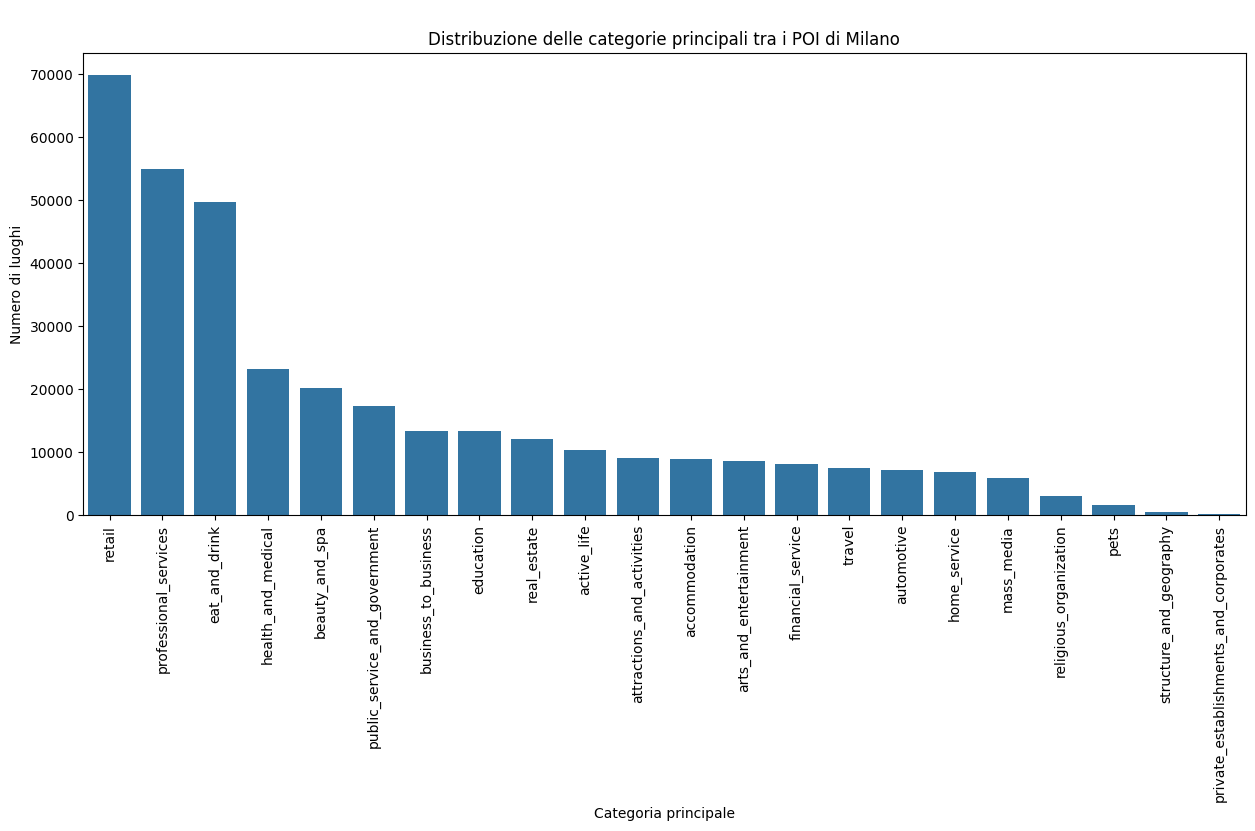

In [ ]:
# Visualizzazione del numero di POI per ogni categoria principale
plt.figure(figsize=(15, 6))
sns.barplot(data=df_category_counts, x='main_category', y='count')
plt.xlabel("Categoria principale")
plt.xticks(rotation=90)
plt.ylabel("Numero di luoghi")
plt.title("\nDistribuzione delle categorie principali tra i POI di Milano")
plt.show()

In [ ]:
# Visualizzazione del numero di POI per ogni sottocategoria
for main_category in main_categories:
    subset = primary_categories[primary_categories['main_category'] == main_category]
    subcategory_counts = subset['category'].value_counts()
    df_subcategory_counts = subcategory_counts.reset_index()
    df_subcategory_counts.columns = ['subcategory', 'count']

    if not subcategory_counts.empty:
        plt.figure(figsize=(30, 6))
        sns.barplot(data=df_subcategory_counts, x='subcategory', y='count')
        plt.xticks(rotation=90)
        plt.xlabel("Sottocategoria")
        plt.ylabel("Numero di luoghi")
        plt.title(f"\nDistribuzione delle sottocategorie per {main_category} tra i POI di Milano")
        plt.show()
        print('\n')

Output hidden; open in https://colab.research.google.com to view.

#### 1.5.2 Analisi del campo confidence

In [ ]:
%%sql
SELECT
    COUNT(*) AS num_poi,
    CAST(SUM(CASE WHEN confidence >= 0.1 THEN 1 ELSE 0 END) AS INT) AS conf_10,
    CAST(SUM(CASE WHEN confidence >= 0.2 THEN 1 ELSE 0 END) AS INT) AS conf_20,
    CAST(SUM(CASE WHEN confidence >= 0.3 THEN 1 ELSE 0 END) AS INT) AS conf_30,
    CAST(SUM(CASE WHEN confidence >= 0.4 THEN 1 ELSE 0 END) AS INT) AS conf_40,
    CAST(SUM(CASE WHEN confidence >= 0.5 THEN 1 ELSE 0 END) AS INT) AS conf_50,
    CAST(SUM(CASE WHEN confidence >= 0.6 THEN 1 ELSE 0 END) AS INT) AS conf_60,
    CAST(SUM(CASE WHEN confidence >= 0.7 THEN 1 ELSE 0 END) AS INT) AS conf_70,
    CAST(SUM(CASE WHEN confidence >= 0.8 THEN 1 ELSE 0 END) AS INT) AS conf_80,
    CAST(SUM(CASE WHEN confidence >= 0.9 THEN 1 ELSE 0 END) AS INT) AS conf_90
FROM places;

,num_poi,conf_10,conf_20,conf_30,conf_40,conf_50,conf_60,conf_70,conf_80,conf_90
0,350832,350568,350568,306150,293886,283224,282306,271902,228450,214368


In [ ]:
%%sql confidence_classes <<
SELECT
    CASE
        WHEN confidence <= 0.2 THEN 'Molto bassa (0-0.2)'
        WHEN confidence > 0.2 AND confidence <= 0.4 THEN 'Bassa (0.2-0.4)'
        WHEN confidence > 0.4 AND confidence <= 0.6 THEN 'Media (0.4-0.6)'
        WHEN confidence > 0.6 AND confidence <= 0.8 THEN 'Alta (0.6-0.8)'
        ELSE 'Molto alta (0.8-1)'
    END AS confidence_class,
    COUNT(*) AS num_poi
FROM places
GROUP BY confidence_class;

In [ ]:
# Ordinamento delle classi di confidenza
category_order = ['Molto bassa (0-0.2)', 'Bassa (0.2-0.4)', 'Media (0.4-0.6)',
                  'Alta (0.6-0.8)', 'Molto alta (0.8-1)']

confidence_classes['confidence_class'] = pd.Categorical(confidence_classes['confidence_class'], categories=category_order, ordered=True)
confidence_classes = confidence_classes.sort_values('confidence_class')
display(confidence_classes)

,confidence_class,num_poi
4,Molto bassa (0-0.2),264
3,Bassa (0.2-0.4),56682
2,Media (0.4-0.6),11580
1,Alta (0.6-0.8),53856
0,Molto alta (0.8-1),228450


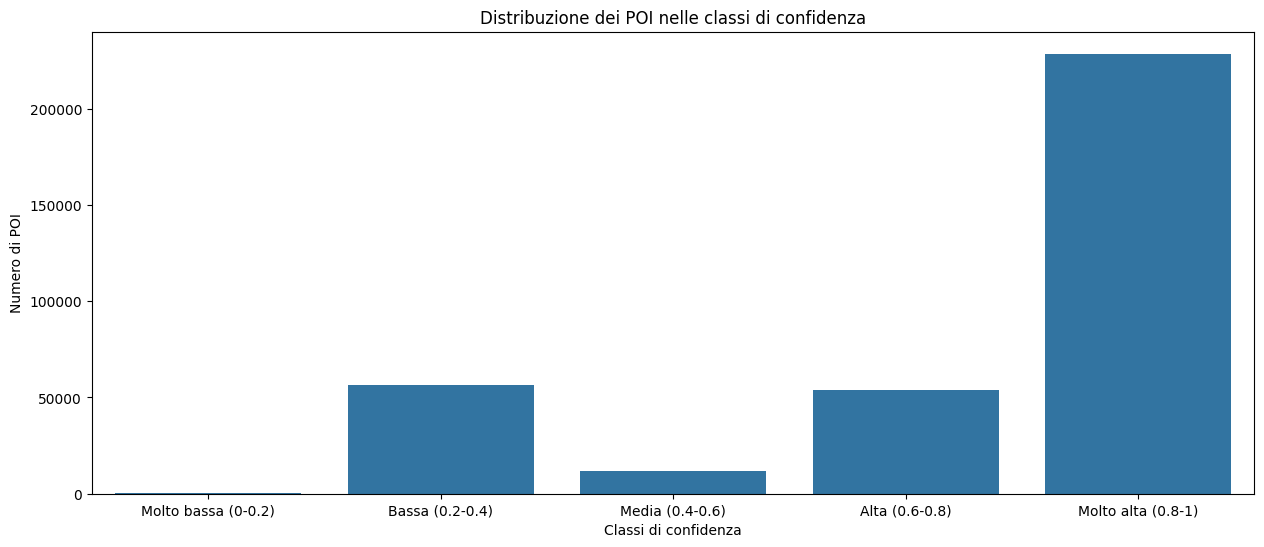

In [ ]:
# Visualizzazione delle classi di confidenza
plt.figure(figsize=(15, 6))
sns.barplot(data=confidence_classes, x="confidence_class", y="num_poi")
plt.xlabel("Classi di confidenza")
plt.ylabel("Numero di POI")
plt.title("Distribuzione dei POI nelle classi di confidenza")
plt.show()

### 1.6 Visualizzazione della mappa dei POI

In [ ]:
%%sql coordinates <<
SELECT id, ST_X(geometry) AS longitude, ST_Y(geometry) AS latitude, names, categories, confidence, addresses
FROM places

In [ ]:
# prompt: Salva coordinates in un file coordinates.csv

# Assuming you have a 'coordinates' DataFrame from the provided SQL query
# Replace this with your actual DataFrame if it's different
# Example DataFrame (replace with your actual 'coordinates' DataFrame)
import pandas as pd


# Funzione per determinare la main category
def get_main_category(category):
    # Verifica se la categoria è una sub-category e restituisce la main category
    for main_category, sub_cat_dict in standard_categories.items():
        if category in sub_cat_dict:
            return main_category
    # Se la categoria è già una main category, la restituiamo tale e quale
    if category in main_categories:
        return category
    # Se la categoria non è né una main né una sub category, la restituiamo invariata
    return category



# Crea la nuova colonna 'main_category' applicando la funzione
coordinates['main_category'] = coordinates['categories'].apply(get_main_category)

def extract_primary_category(main_category_str):
    try:
        # Carica la stringa JSON
        category_data = json.loads(main_category_str)
        # Estrai il valore sotto "primary"
        return category_data.get('primary', None)
    except (json.JSONDecodeError, TypeError):
        return None

# Applica la funzione alla colonna 'main_category'
coordinates['main_category'] = coordinates['main_category'].apply(extract_primary_category)

def find_main_category(category, sub_cat_dict):
    """
    Funzione ricorsiva per trovare la main category di una sub-category.
    Se la categoria è una sub-category, restituisce la main category corrispondente.
    Se la categoria è sconosciuta, restituisce "unknown".
    """
    for main_category, sub_dict in sub_cat_dict.items():
        # Se la categoria è una main category, la restituisce direttamente
        if category == main_category:
            return main_category

        # Se la categoria è una sub-category diretta, restituisce la main category corrispondente
        if category in sub_dict:
            return main_category

        # 🔄 Controlliamo se la categoria è in una sotto-sotto categoria
        for sub_category, nested_dict in sub_dict.items():
            if isinstance(nested_dict, dict):  # Se è un dizionario, continuiamo la ricerca
                if category in nested_dict:
                    return main_category  # Trovato, restituisce la main category
                else:
                    # 🔄 Ricorsione per cercare nei livelli più profondi
                    result = find_main_category(category, {sub_category: nested_dict})
                    if result and result != "unknown":
                        return main_category

    return "unknown"  # Se non viene trovata in nessun livello, restituisce "unknown"

# Applica la funzione di sostituzione
coordinates['main_category'] = coordinates['main_category'].apply(
    lambda cat: find_main_category(cat, standard_categories) if pd.notna(cat) else "unknown"
)

# Stampa il risultato
print(coordinates)

def find_group_category(main_category, category_tree):
    """
    Trova il 'group_category' per una data 'main_category'.
    Se non trova una corrispondenza, restituisce 'unknown'.
    """
    for group, main_list in category_tree.items():
        if main_category in main_list:
            return group
    return "unknown"  # Se la categoria non è trovata, restituiamo "unknown"

# Applichiamo la funzione alla colonna 'main_category' per creare la nuova colonna 'group_category'
coordinates['group_category'] = coordinates['main_category'].apply(
    lambda cat: find_group_category(cat, albero) if pd.notna(cat) else "unknown"
)

# Stampa il risultato
print(coordinates)




                                      id  longitude   latitude  \
0       08f8e62c50383b8803fcf09567974e40   9.221615  45.490589   
1       08f98f0b29285aea03652e222d82119b   9.202782  45.474894   
2       08f489ac041b5b32030f50bb7abb55ce   9.206607  45.414422   
3       08f26c83b324d08903167da4a6151af3   9.246021  45.470652   
4       08f6d693050420a903d8dc9a14652b7d   9.167222  45.489444   
...                                  ...        ...        ...   
350827  08f1ea5730134926033c31cb09db6091   9.177689  45.416579   
350828  08f1ea58f664c300035eabd36c467577   9.235662  45.490585   
350829  08f1ea5128458888031d43eb3e584b21   9.101926  45.477619   
350830  08f1f8b232473501037caa739acdfda8   9.251258  45.509002   
350831  08f1f1d48970050003c9673a0902cfc1   9.175921  45.452144   

                                                    names  \
0       {"primary":"Arteinparete Deco","common":null,"...   
1           {"primary":"IFDM","common":null,"rules":null}   
2       {"primary":"Spaz

In [ ]:
# Salva il DataFrame 'coordinates' in un file CSV
coordinates.to_csv('', index=False)

In [ ]:
map_poi = folium.Map(location=[45.4636707, 9.1881263], zoom_start=12)

# Specifiche di ogni POI
for _, row in coordinates.iterrows():
    names = json.loads(row['names'])
    name = names.get('primary')
    addresses = json.loads(row['addresses'])
    address = addresses[0].get('freeform') + ', ' +  addresses[0].get('postcode')
    categories = json.loads(row['categories'])
    category = categories.get('primary')

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=0.1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.9,
        tooltip=f"<b>Nome:</b> {name}<br><b>Indirizzo:</b> {address}<br><b>Categoria:</b> {category}<br><b>Confidenza:</b> {row['confidence']}"
    ).add_to(map_poi)

# Visualizzazione della mappa
print('\nMappa dei POI di Milano:\n')
map_poi

# Salvataggio della mappa
# map_poi.save('/content/drive/MyDrive/Stage/file/poi/poi_milano_map.html')


Mappa dei POI di Milano:



KeyboardInterrupt: 